
# Phân tích doanh thu và hiệu suất bán hàng
- Tổng doanh thu theo ngày, tuần, tháng, xác định ngày nào trong tuần bán chạy nhất của tất cả cửa hàng và của từng cửa hàng.
- So sánh hiệu suất bán hàng của từng cửa hàng
- Phân tích tác động của giảm giá (số lượng bán ra và doanh thu trước và sau giảm giá)

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sys
import os
sys.path.append('../../../scripts/')
import data_cleaning

# 1. Import data
Nhập dữ liệu đã qua xử lý, data đã clean 20240722

In [53]:
df_menuitem = pd.read_csv("../../../data/processed/20240722/2.menuitem_20240722.csv")
df_menuitem.head()

,MD5KEY_MENUITEM,MD5KEY_ORDERSALE,CategoryDescription,DepartmentDescription,Description,StoreNumber,TaxAmount,AdjustedPrice,DiscountAmount,Price,Quantity,PLU,Id,date,SalesAmount,day_of_week
0,001E0224E4EDA63D6FED96D59E0C1E76,072D3B76BE58E4553A373AF3206D2CA5,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0.6975,7.75,0.00,7.75,1,111000041,326,2015-03-05,7.75,Thursday
1,003E4E20196B2F5BDD33CE06D2943EF4,14811D4F3458058007B0B6908C2DA393,Fountain,Fountain Drink 21 oz.,21oz Fountain Drink,46673,0.1530,1.70,0.00,1.70,1,212000126,280,2015-03-05,1.70,Thursday
2,012A55E5551C95A559A7B074AE85117E,22FA6C39B7A15ABB6EB568E66A6B30E1,6 Inch,6 Inch Sub,B.M.T. 6 inch,12631,0.3230,3.64,0.61,4.25,1,121000008,8,2015-03-05,3.64,Thursday
3,01B07F1C6DC6945796571FC78735DA16,915B69612845BBD974C39AC105F5CA8C,6 Inch,6 Inch Sub,Veggie Delite 6 inch,12631,0.3328,3.75,0.00,3.75,1,121000001,91,2015-03-05,3.75,Thursday
4,02DE19974DE5304BF243A1C2EC639495,CD6386C802450EDCF13A3D112D1F86EC,Add On,Add On 6in Portion,Avocado Add6in,12631,0.0443,0.50,0.00,0.50,1,175000062,564,2015-03-05,0.50,Thursday


In [54]:
df_ordersale = pd.read_csv("../../../data/processed/20240722/1.pos_ordersale_20240722.csv")
df_ordersale.head()

,MD5KEY_ORDERSALE,ChangeReceived,OrderNumber,TaxAmount,MealLocation,TransactionId,StoreNumber,date
0,00BCB738A1F814DB960C25012E9913DF,0.00,67,0.56,0,67,46673,2015-03-05
1,03438C257BC2DD0037F35EC8BFC0C8E2,3.46,39,0.54,0,39,12631,2015-03-05
2,04AEF56CF3130AC1EFAD41C470F5245D,0.00,81,0.69,0,79,46673,2015-03-05
3,04BBFAD4E73C30EE2EC3B4E52509637C,0.00,159,1.16,0,159,12631,2015-03-05
4,061AE382DC127057E8ADBBF869CFB361,0.00,51,0.00,0,51,12631,2015-03-05


# 2. Phân tích doanh thu ngày và ngày trong tuần
Phân tích doanh thu thao ngày, ngày trong tuần để hiểu rõ hơn về xu hướng doanh thu của tổng quan và của từng cửa hàng.

## 2.1 Doanh thu
Để phân tích doanh cần các trường trong file menuitem:
- SalesAmount
- date
- day_of_week

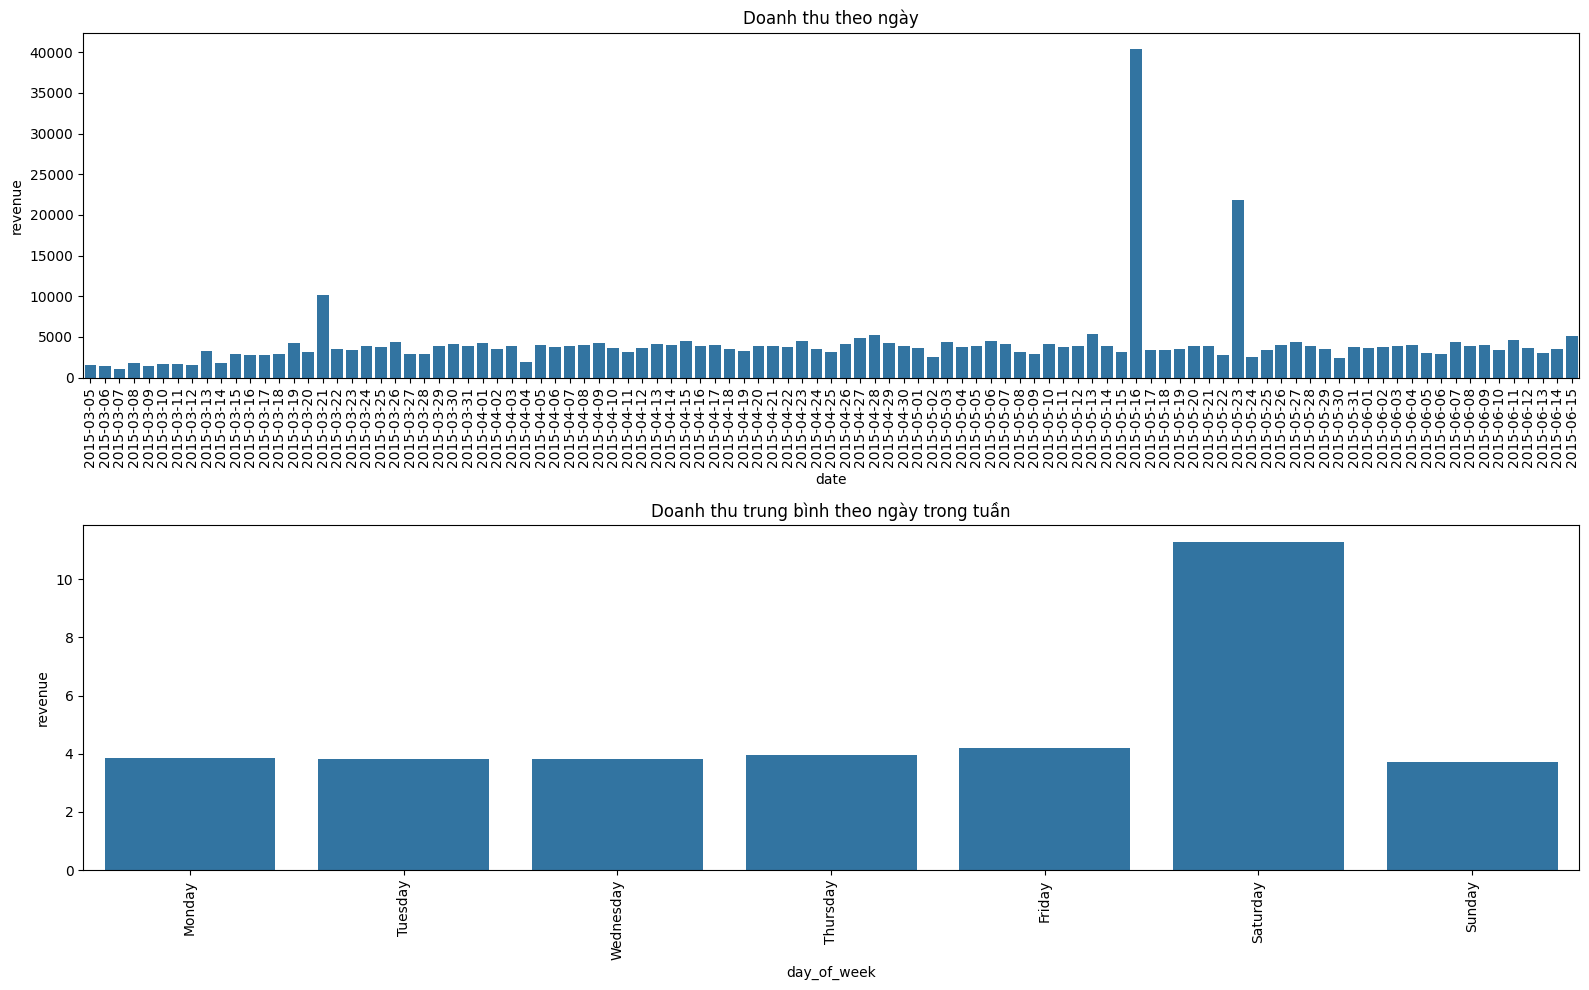

In [111]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(data=df_menuitem.groupby('date').agg(revenue=('SalesAmount', 'sum')),
             x='date',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=df_menuitem.groupby('day_of_week').agg(revenue=('SalesAmount', 'mean')),
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình theo ngày trong tuần")

plt.tight_layout()
plt.show()

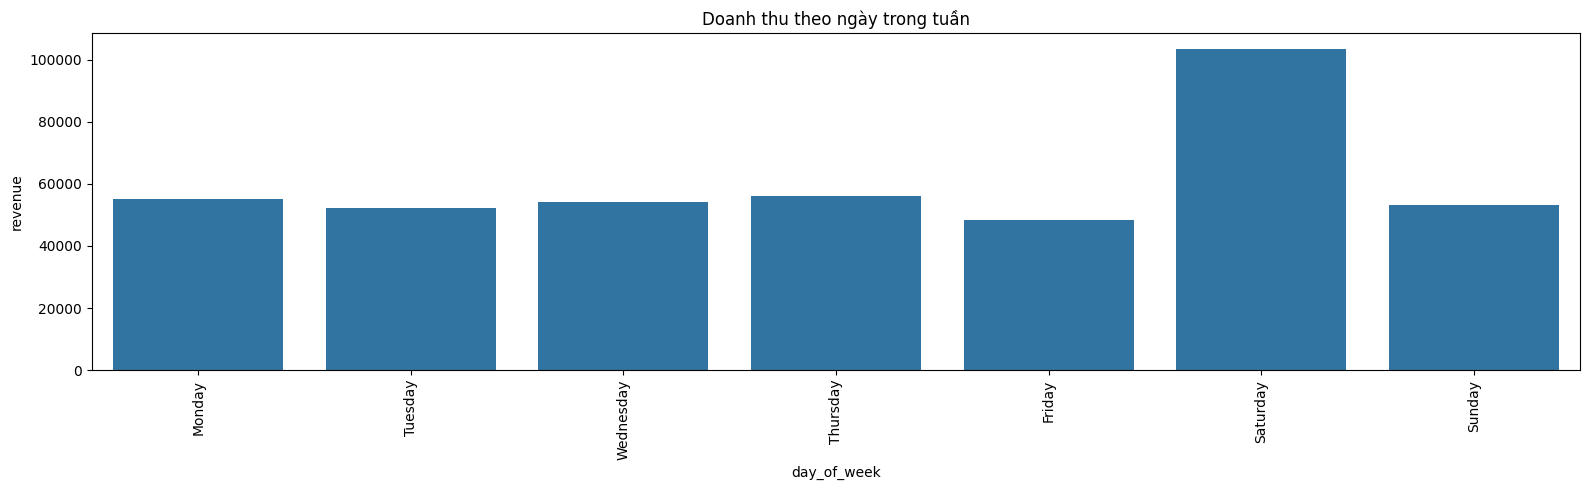

In [123]:
plt.figure(figsize=(16, 5))

sns.barplot(data=df_menuitem.groupby('day_of_week').agg(revenue=('SalesAmount', 'sum')),
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày trong tuần")

plt.tight_layout()
plt.show()

### Check các ngày doanh thu đột biến là thứ mấy

In [56]:
print(df_menuitem[df_menuitem['date'] == '2015-03-21'].loc[:, 'day_of_week'].unique())
print(df_menuitem[df_menuitem['date'] == '2015-05-16'].loc[:, 'day_of_week'].unique())
print(df_menuitem[df_menuitem['date'] == '2015-05-23'].loc[:, 'day_of_week'].unique())

['Saturday']
['Saturday']
['Saturday']


### 2.1.1 Tách outliers Quantity

In [57]:
# Tính Q1_quantity (25th percentile) và Q3_Quantity (75th percentile)
Q1_quantity = df_menuitem['Quantity'].quantile(0.25)
Q3_quantity = df_menuitem['Quantity'].quantile(0.75)

# Tính IQR_quantity
IQR_quantity = Q3_quantity - Q1_quantity

# Xác định giới hạn dưới và trên
lower_bound_quantity = Q1_quantity - 1.5 * IQR_quantity
upper_bound_quantity = Q3_quantity + 1.5 * IQR_quantity

# Xác định giá trị ngoại lai
outliers_quantity = df_menuitem[(df_menuitem['Quantity'] < lower_bound_quantity) | (df_menuitem['Quantity'] > upper_bound_quantity)].copy()
non_outliers_quantity = df_menuitem[~((df_menuitem['Quantity'] < lower_bound_quantity) | (df_menuitem['Quantity'] > upper_bound_quantity))].copy()

In [58]:
print("Số hàng menuitem:", df_menuitem.shape[0])
print("Tổng hàng outliers và non_outliers:", outliers_quantity.shape[0] + non_outliers_quantity.shape[0])
print("% outliers:", outliers_quantity.shape[0] / df_menuitem.shape[0] * 100)
print("Số hàng outliers:", outliers_quantity.shape[0])
print("Số hàng non_outliers:", non_outliers_quantity.shape[0])

Số hàng menuitem: 91420
Tổng hàng outliers và non_outliers: 91420
% outliers: 7.5082038941150735
Số hàng outliers: 6864
Số hàng non_outliers: 84556


### 2.1.2 Doanh thu tổng non_outliers

In [59]:
# Doanh thu tổng theo ngày
revenue_by_day = non_outliers_quantity.groupby(['date', 'day_of_week']).agg(revenue=('SalesAmount', 'sum')).reset_index()

# Doanh thu tổng ngày trong tuần
revenue_day_of_week = revenue_by_day.groupby('day_of_week').agg(revenue=('revenue', 'mean')).sort_values(by='revenue').reset_index()


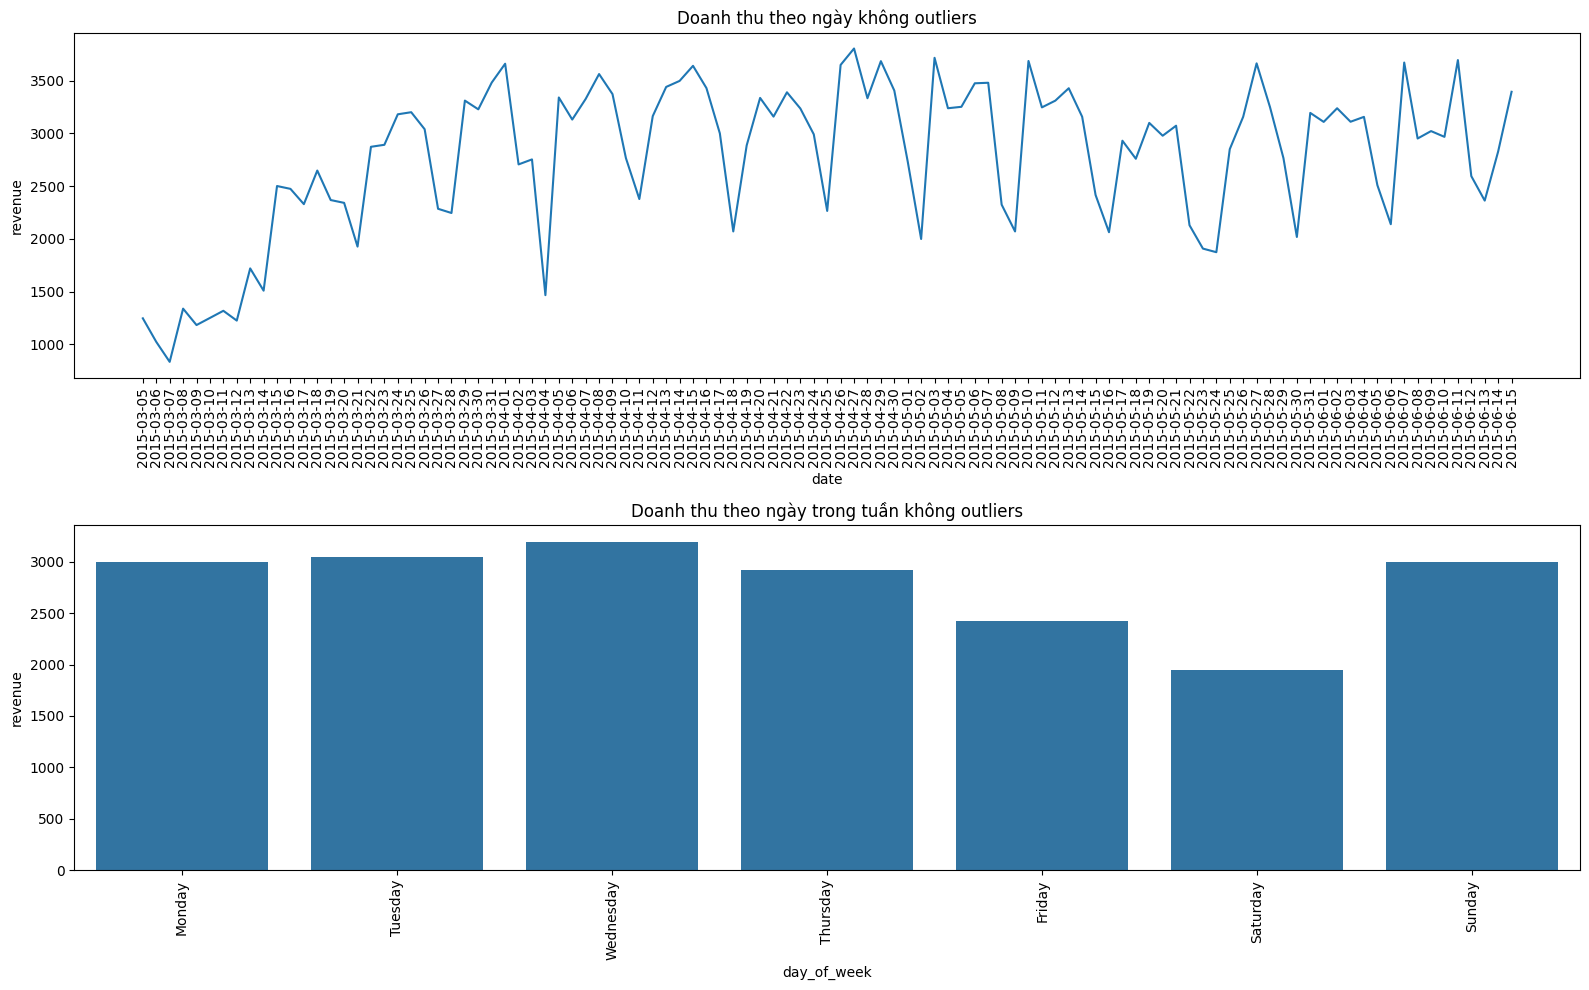

In [60]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=revenue_by_day,
             x='date',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày không outliers")

plt.subplot(2, 1, 2)
sns.barplot(data=revenue_day_of_week,
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày trong tuần không outliers")

plt.tight_layout()
plt.show()

Note: Khoảng thời gian 2 tuần đầu hơi ít so với khoảng thời gian còn lại.
- Data có vấn đề gì không? (Không đủ dữ liệu để tìm nguyên nhân)
- Biểu đồ doanh thu theo ngày có tính chu kỳ, dựa theo biểu đồ doanh thu ngày trong tuần xác định điều đó

Nhận xét: Doanh thu có xu hướng tăng từ thứ 2 tới ths 4 và có xu hướng giảm từ thứ 5 tới thứ 7 và tăng trở lại vào CN

#### 2.1.2.1 Kiểm tra dữ liệu

In [61]:
revenue_by_day

,date,day_of_week,revenue
0,2015-03-05,Thursday,1246.79
1,2015-03-06,Friday,1023.68
2,2015-03-07,Saturday,834.16
3,2015-03-08,Sunday,1338.52
4,2015-03-09,Monday,1183.01
...,...,...,...
98,2015-06-11,Thursday,3693.93
99,2015-06-12,Friday,2594.26
100,2015-06-13,Saturday,2362.31
101,2015-06-14,Sunday,2827.45


In [62]:
revenue_day_of_week

,day_of_week,revenue
0,Saturday,1949.969333
1,Friday,2423.059333
2,Thursday,2921.995333
3,Sunday,2996.866667
4,Monday,3001.897333
5,Tuesday,3044.854286
6,Wednesday,3193.961429


### 2.1.3 Doanh thu tổng outliers

In [63]:
# Doanh thu tổng theo ngày
revenue_by_day_outliers = outliers_quantity.groupby(['date', 'day_of_week']).agg(revenue=('SalesAmount', 'sum')).reset_index()

# Doanh thu tổng ngày trong tuần
revenue_day_of_week_outliers = revenue_by_day_outliers.groupby('day_of_week').agg(revenue=('revenue', 'mean')).sort_values(by='revenue').reset_index()

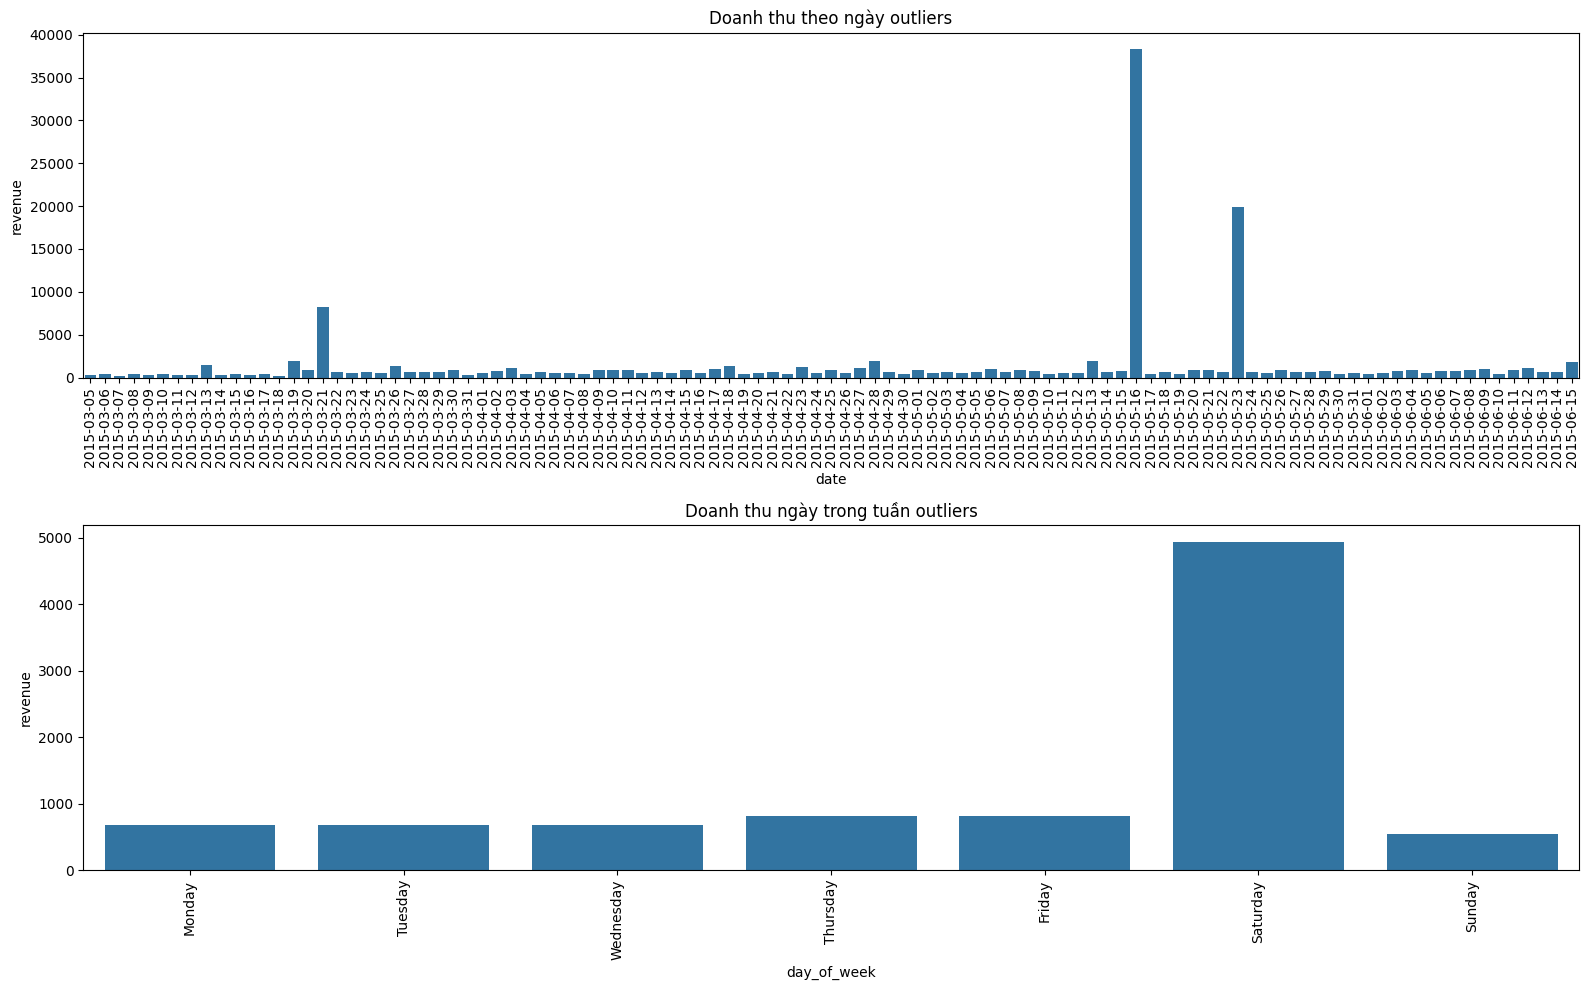

In [64]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.barplot(data=revenue_by_day_outliers,
             x='date',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu theo ngày outliers")

plt.subplot(2, 1, 2)
sns.barplot(data=revenue_day_of_week_outliers,
             x='day_of_week',
             y='revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu ngày trong tuần outliers")

plt.tight_layout()
plt.show()

Note: (giả thuyết)
- Thứ 7 có nhiều outliers
- Có thể thứ 7 khách nhỏ giảm khách lớn tăng 
Note: Outliers thường vào ngày thứ 7 cho thấy có thể có những sự kiện đặc biệt diễn ra trong ngày này như: đặt tiệc, sự kiện, hoặc các chương trình khuyến mãi đặc biệt

Analysis: Để xác nhận giả thuyết này, cần phân tích thêm dữ liệu về số lượng đơn hàng, doanh thu mỗi đơn hàng, và loại hình (ăn tại chỗ hoặc mang đi) được sử dụng vào các ngày thứ 7.

#### 2.1.3.1 Kiểm tra và xác nhận lại dữ liệu ngoại lai

In [65]:
revenue_by_day_outliers.head()

,date,day_of_week,revenue
0,2015-03-05,Thursday,312.00
1,2015-03-06,Friday,404.60
2,2015-03-07,Saturday,201.45
3,2015-03-08,Sunday,435.66
4,2015-03-09,Monday,257.48


In [66]:
revenue_day_of_week_outliers

,day_of_week,revenue
0,Sunday,550.019333
1,Tuesday,675.612857
2,Monday,676.065333
3,Wednesday,682.364286
4,Friday,808.228667
5,Thursday,813.735333
6,Saturday,4941.661333


### 2.1.4 Xác nhận giả thuyết sang phần 2.2
Để xác nhận giả thuyết từ 2.1.3 khi thứ 7 dữ liệu ngoại lại nhiều, cần phân tích thêm dữ liệu về:
- Doanh thu trung bình mỗi đơn hàng
- Số lượng đơn hàng
- Trung bình món ăn mỗi đơn hàng
- Loại hình (ăn tại chỗ hoặc mang đi) được sử dụng vào các ngày thứ 7.

## 2.2 Kiểm tra dữ liệu thứ 7 so với các ngày khác trong tuần
Cần dữ liệu từ ordersale và menuitem để lấy được loại hình ăn uống (tại chỗ, mang đi)

### 2.2.1 Chuẩn bị dữ liệu

#### 2.2.1.1 Merge dữ liệu

In [67]:
df_ordersale

,MD5KEY_ORDERSALE,ChangeReceived,OrderNumber,TaxAmount,MealLocation,TransactionId,StoreNumber,date
0,00BCB738A1F814DB960C25012E9913DF,0.00,67,0.56,0,67,46673,2015-03-05
1,03438C257BC2DD0037F35EC8BFC0C8E2,3.46,39,0.54,0,39,12631,2015-03-05
2,04AEF56CF3130AC1EFAD41C470F5245D,0.00,81,0.69,0,79,46673,2015-03-05
3,04BBFAD4E73C30EE2EC3B4E52509637C,0.00,159,1.16,0,159,12631,2015-03-05
4,061AE382DC127057E8ADBBF869CFB361,0.00,51,0.00,0,51,12631,2015-03-05
...,...,...,...,...,...,...,...,...
43223,FBEFF26C8C626C303C191A42C8CCFBDA,0.00,8014,1.58,0,8014,20974,2015-06-15
43224,FC277A831486F1ADD27AE22FF2BDF559,0.03,15972,0.47,0,15972,4904,2015-06-15
43225,FD23743074BCCB6E0847269D09F458AE,0.00,16014,0.00,1,16014,4904,2015-06-15
43226,FD570797AC0A9AFC3953A30EC5355829,0.00,7149,0.00,1,7149,46673,2015-06-15


In [68]:
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week'],
      dtype='object')

In [69]:
# Merge dữ liệu ordersale và menuitem
merged_ordersale_menuitem = pd.merge(df_ordersale, df_menuitem, on='MD5KEY_ORDERSALE', how='left')
merged_ordersale_menuitem.head()

,MD5KEY_ORDERSALE,ChangeReceived,OrderNumber,TaxAmount_x,MealLocation,TransactionId,StoreNumber_x,date_x,MD5KEY_MENUITEM,CategoryDescription,...,TaxAmount_y,AdjustedPrice,DiscountAmount,Price,Quantity,PLU,Id,date_y,SalesAmount,day_of_week
0,00BCB738A1F814DB960C25012E9913DF,0.00,67,0.56,0,67,46673,2015-03-05,F723AFAEC05500ED00EE7B642DBBEF50,Fountain,...,0.1530,1.70,0.0,1.70,1.0,212000126.0,280.0,2015-03-05,1.70,Thursday
1,00BCB738A1F814DB960C25012E9913DF,0.00,67,0.56,0,67,46673,2015-03-05,FBDE984CE2674869B840D31AE7E4C35A,6 Inch,...,0.4050,4.50,0.0,4.50,1.0,121000004.0,2.0,2015-03-05,4.50,Thursday
2,03438C257BC2DD0037F35EC8BFC0C8E2,3.46,39,0.54,0,39,12631,2015-03-05,6B19A97889A7B5902E6E7B489F403067,6 Inch,...,0.3771,4.25,0.0,4.25,1.0,121000006.0,75.0,2015-03-05,4.25,Thursday
3,03438C257BC2DD0037F35EC8BFC0C8E2,3.46,39,0.54,0,39,12631,2015-03-05,B54026720FF6611399B7451FCC8DC4B2,Bottled Beverage,...,0.1553,1.75,0.0,1.75,1.0,221000135.0,278.0,2015-03-05,1.75,Thursday
4,04AEF56CF3130AC1EFAD41C470F5245D,0.00,81,0.69,0,79,46673,2015-03-05,BC939C43F3BEB1DCE24AAD956919832C,Bottled Beverage,...,0.1710,1.90,0.0,1.90,1.0,221000134.0,365.0,2015-03-05,1.90,Thursday


In [70]:
# Kiểm tra doanh thu tổng trước và sau merge 
print(df_menuitem['SalesAmount'].sum())
print(merged_ordersale_menuitem['SalesAmount'].sum())

422607.57
422607.57


#### 2.2.1.2 Groupby dữ liệu theo đơn hàng

In [71]:
merged_ordersale_menuitem.columns

Index(['MD5KEY_ORDERSALE', 'ChangeReceived', 'OrderNumber', 'TaxAmount_x',
       'MealLocation', 'TransactionId', 'StoreNumber_x', 'date_x',
       'MD5KEY_MENUITEM', 'CategoryDescription', 'DepartmentDescription',
       'Description', 'StoreNumber_y', 'TaxAmount_y', 'AdjustedPrice',
       'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id', 'date_y',
       'SalesAmount', 'day_of_week'],
      dtype='object')

In [72]:
# Group các trường cần thiết để tính doanh thu, số lượng đơn hàng, loại hình
merged_ordersale_menuitem_groupby = merged_ordersale_menuitem.groupby(['MD5KEY_ORDERSALE', 'date_x', 'day_of_week', 'StoreNumber_x', 'MealLocation']).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum')
).reset_index()

merged_ordersale_menuitem_groupby

,MD5KEY_ORDERSALE,date_x,day_of_week,StoreNumber_x,MealLocation,Quantity,SalesAmount
0,00040FB2079EE37A1A3347134FDA1222,2015-04-03,Friday,12631,0,1.0,6.00
1,000487D84122ECFC7C2B0681D7847D07,2015-04-03,Friday,12631,0,4.0,28.40
2,0006541E961609F6EA9B93AF996791FA,2015-03-19,Thursday,4904,1,1.0,4.25
3,0007198A6EA115A618FB1F7A47DA5A94,2015-04-16,Thursday,12631,0,1.0,6.00
4,0009AF6BC70525EA7865AB795C651219,2015-04-22,Wednesday,12631,0,2.0,0.00
...,...,...,...,...,...,...,...
40616,FFF4B340CBD214BD2A0C12944DD6FC4C,2015-04-25,Saturday,4904,1,1.0,5.50
40617,FFF4B38DC800DE5784EC2F27909AB4B9,2015-04-09,Thursday,46673,0,3.0,9.25
40618,FFF9C0AFD57C0B07E3ADE021C41BC222,2015-03-21,Saturday,4904,0,1.0,6.75
40619,FFFB7296078113301047E98795ED0836,2015-04-28,Tuesday,4904,1,3.0,6.00


### 2.2.2 Doanh thu trung bình mỗi đơn hàng

In [73]:
# Group by date
groupby_day_revenue = merged_ordersale_menuitem_groupby.groupby(['date_x', 'day_of_week']).agg(revenue=('SalesAmount', 'mean')).reset_index()

# Group day_of_week
groupby_day_of_week_revenue = groupby_day_revenue.groupby('day_of_week').agg(avg_revenue=('revenue', 'mean')).reset_index()

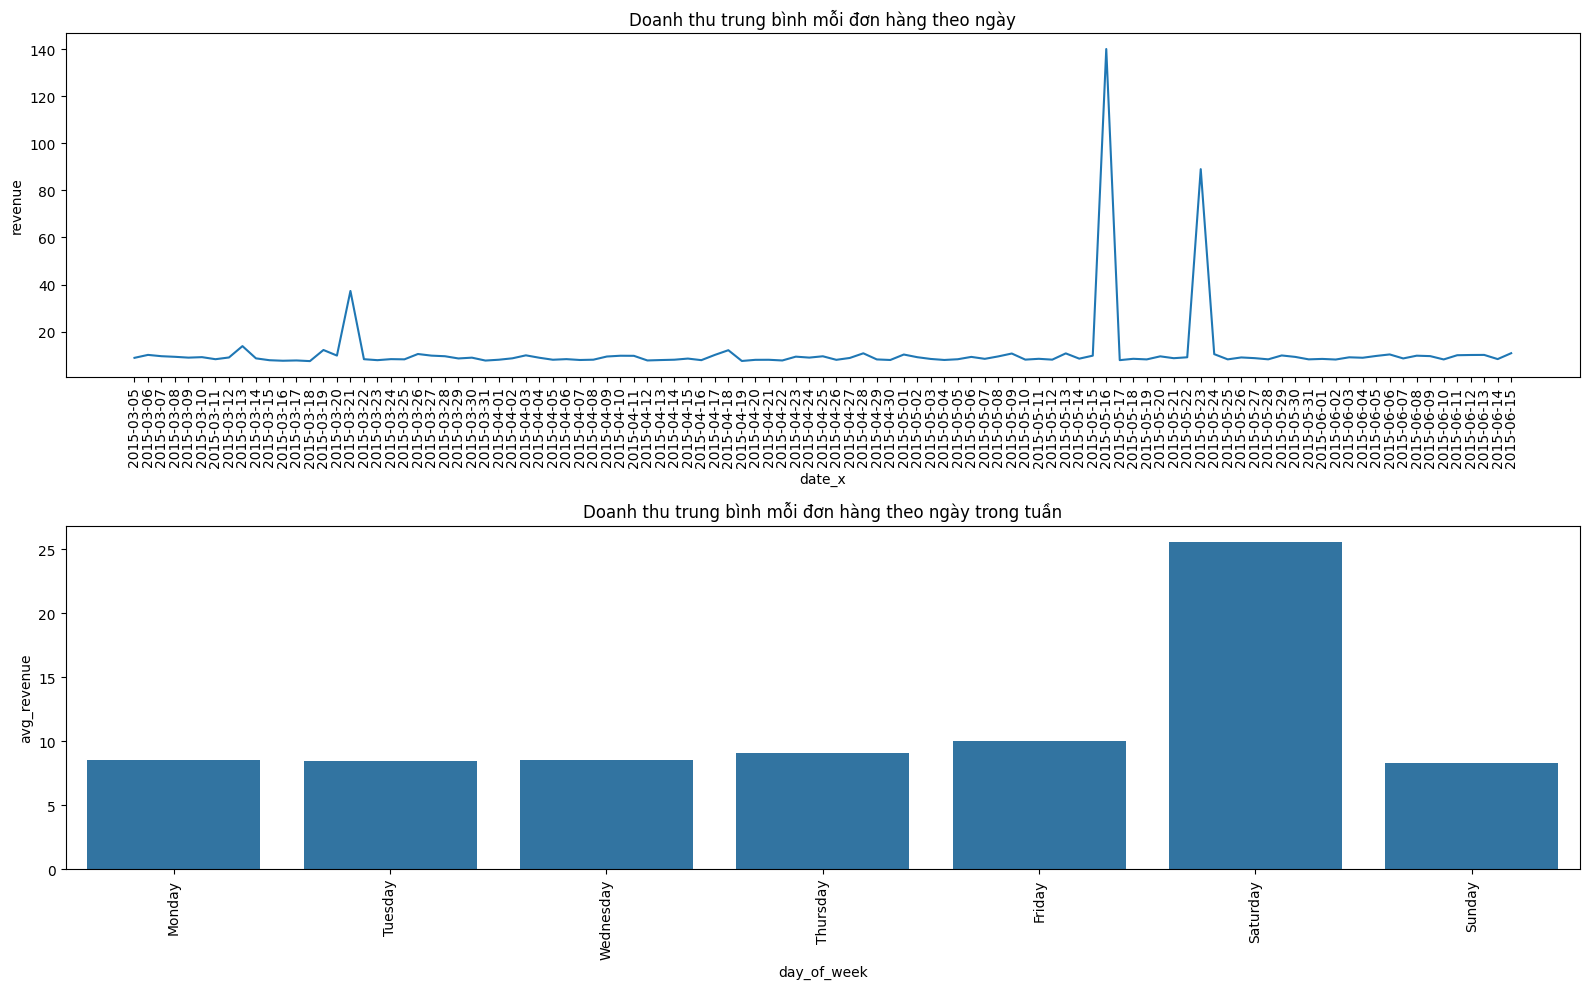

In [74]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_revenue,
             x='date_x',
             y='revenue')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình mỗi đơn hàng theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=groupby_day_of_week_revenue,
             x='day_of_week',
             y='avg_revenue',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình mỗi đơn hàng theo ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.2.3 Số lượng đơn hàng

In [75]:
merged_ordersale_menuitem_groupby.head()

,MD5KEY_ORDERSALE,date_x,day_of_week,StoreNumber_x,MealLocation,Quantity,SalesAmount
0,00040FB2079EE37A1A3347134FDA1222,2015-04-03,Friday,12631,0,1.0,6.00
1,000487D84122ECFC7C2B0681D7847D07,2015-04-03,Friday,12631,0,4.0,28.40
2,0006541E961609F6EA9B93AF996791FA,2015-03-19,Thursday,4904,1,1.0,4.25
3,0007198A6EA115A618FB1F7A47DA5A94,2015-04-16,Thursday,12631,0,1.0,6.00
4,0009AF6BC70525EA7865AB795C651219,2015-04-22,Wednesday,12631,0,2.0,0.00


In [76]:
# Group by date
groupby_day_order = merged_ordersale_menuitem_groupby.groupby(['date_x', 'day_of_week']).agg(total_order=('MD5KEY_ORDERSALE', 'count')).reset_index()

# Group day_of_week
groupby_day_of_week_order = groupby_day_order.groupby('day_of_week').agg(avg_order=('total_order', 'mean')).reset_index()

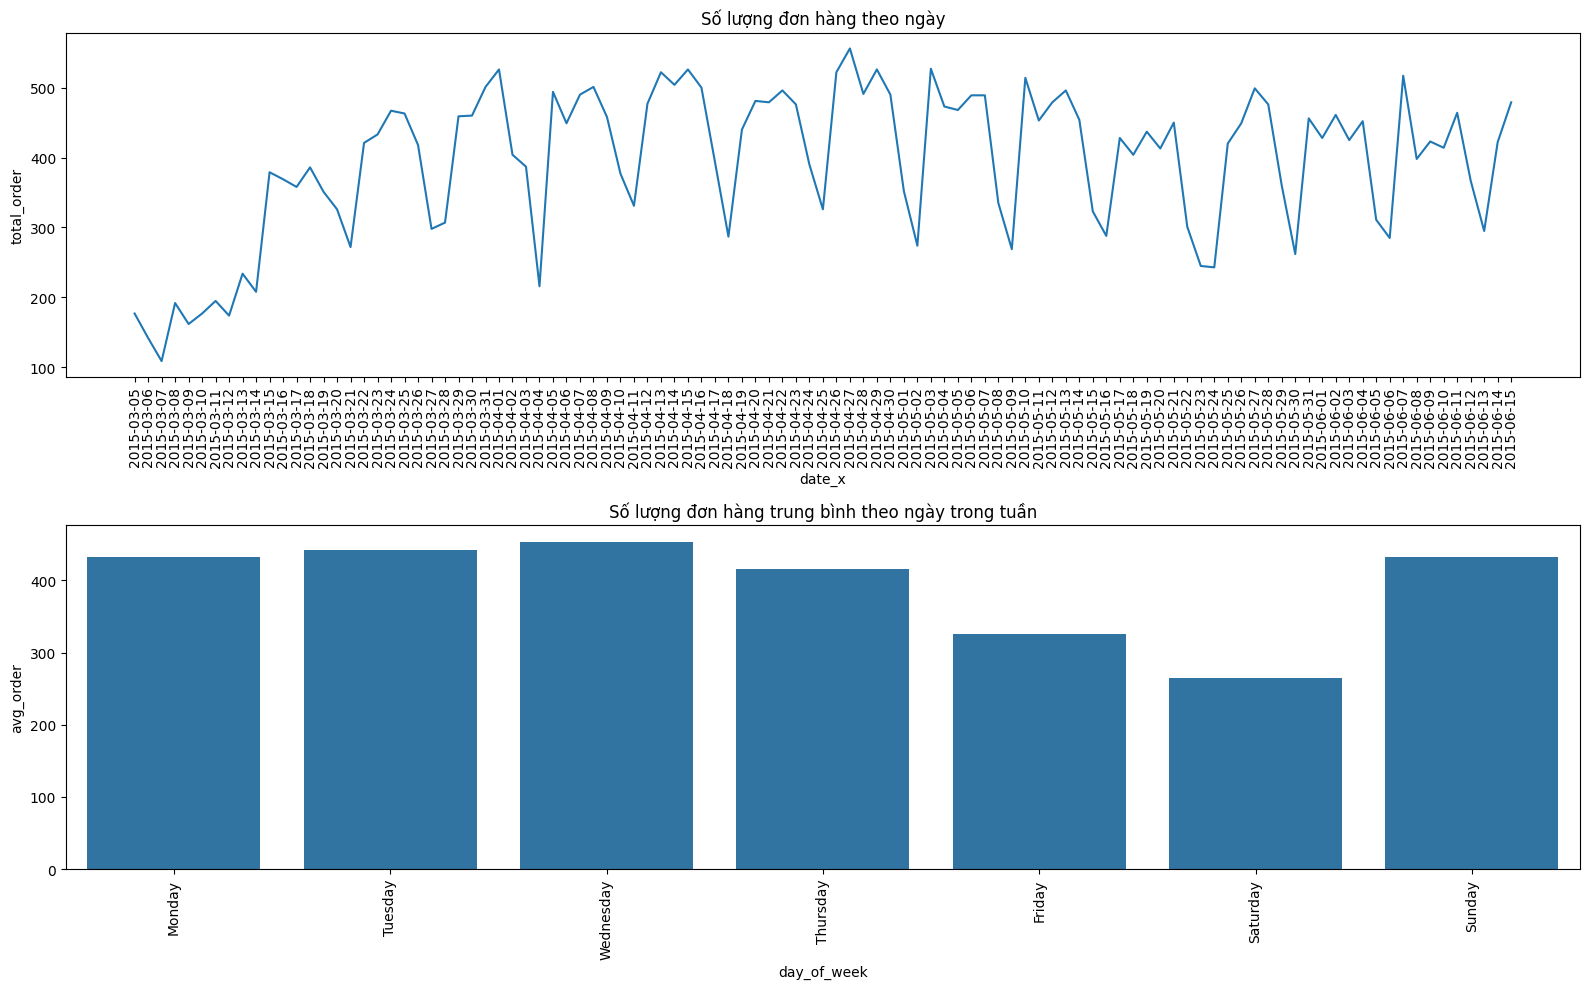

In [77]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_order,
             x='date_x',
             y='total_order')
plt.xticks(rotation=90, ha='center')
plt.title("Số lượng đơn hàng theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=groupby_day_of_week_order,
             x='day_of_week',
             y='avg_order',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Số lượng đơn hàng trung bình theo ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.2.4 Số lượng món ăn mỗi đơn hàng

In [78]:
# Group by date
groupby_day_quantity = merged_ordersale_menuitem_groupby.groupby(['date_x', 'day_of_week']).agg(quantity=('Quantity', 'sum')).reset_index()

# Group day_of_week
groupby_day_of_week_quantity = groupby_day_quantity.groupby('day_of_week').agg(avg_quantity=('quantity', 'mean')).reset_index()

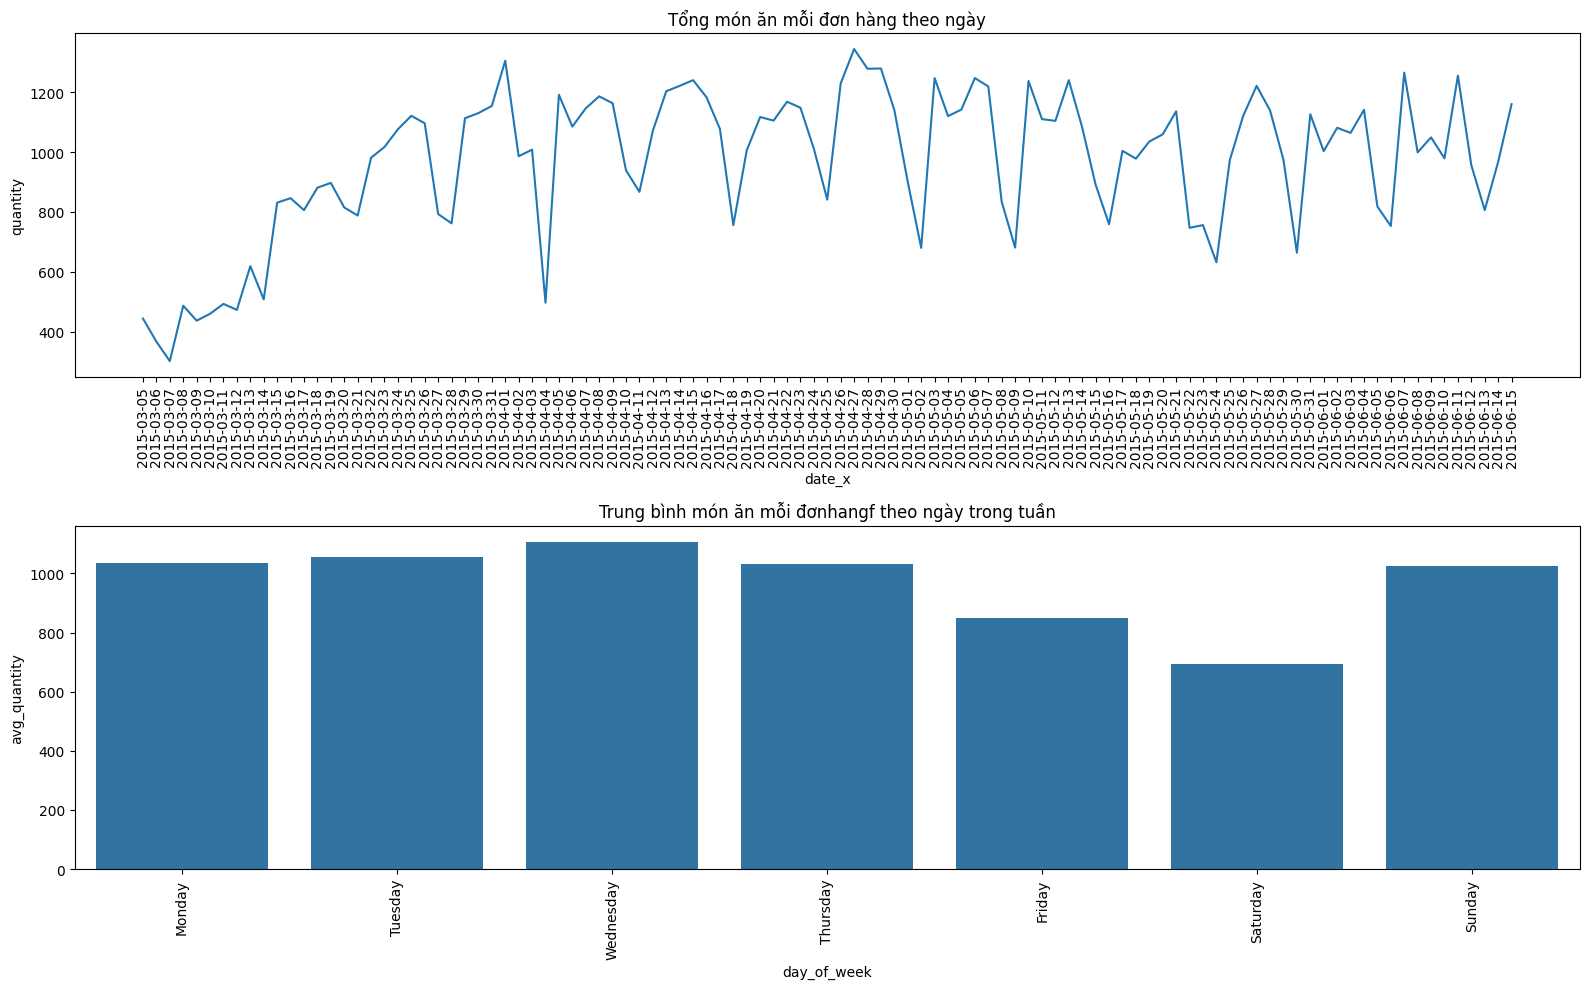

In [124]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_quantity,
             x='date_x',
             y='quantity')
plt.xticks(rotation=90, ha='center')
plt.title("Tổng món ăn mỗi đơn hàng theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=groupby_day_of_week_quantity,
             x='day_of_week',
             y='avg_quantity',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Trung bình món ăn mỗi đơnhangf theo ngày trong tuần")

plt.tight_layout()
plt.show()

### 2.2.4 Loại hình đơn hàng (ăn tại chỗ, mang đi)

In [80]:
# Group by date
groupby_day_meallocation = merged_ordersale_menuitem_groupby.groupby(['date_x', 'day_of_week', 'MealLocation']).agg(quantity=('MealLocation', 'count')).reset_index()

# Group day_of_week
groupby_day_of_week_meallocation = groupby_day_meallocation.groupby(['day_of_week', 'MealLocation']).agg(avg_quantity=('quantity', 'mean')).reset_index()

#### 2.2.4.2 Thêm cột MealLocationText
Làm rõ ngữ cảnh

In [81]:
# Add column MealLocationText
groupby_day_meallocation['MealLocationText'] = groupby_day_meallocation['MealLocation'].apply(lambda x: 'Eat' if x == 0 else 'ToGo')
groupby_day_of_week_meallocation['MealLocationText'] = groupby_day_of_week_meallocation['MealLocation'].apply(lambda x: 'Eat' if x == 0 else 'ToGo')

In [82]:
groupby_day_meallocation.head()

,date_x,day_of_week,MealLocation,quantity,MealLocationText
0,2015-03-05,Thursday,0,168,Eat
1,2015-03-05,Thursday,1,9,ToGo
2,2015-03-06,Friday,0,135,Eat
3,2015-03-06,Friday,1,7,ToGo
4,2015-03-07,Saturday,0,102,Eat


In [83]:
groupby_day_of_week_meallocation.head()

,day_of_week,MealLocation,avg_quantity,MealLocationText
0,Friday,0,254.266667,Eat
1,Friday,1,72.200000,ToGo
2,Monday,0,351.733333,Eat
3,Monday,1,80.733333,ToGo
4,Saturday,0,200.933333,Eat


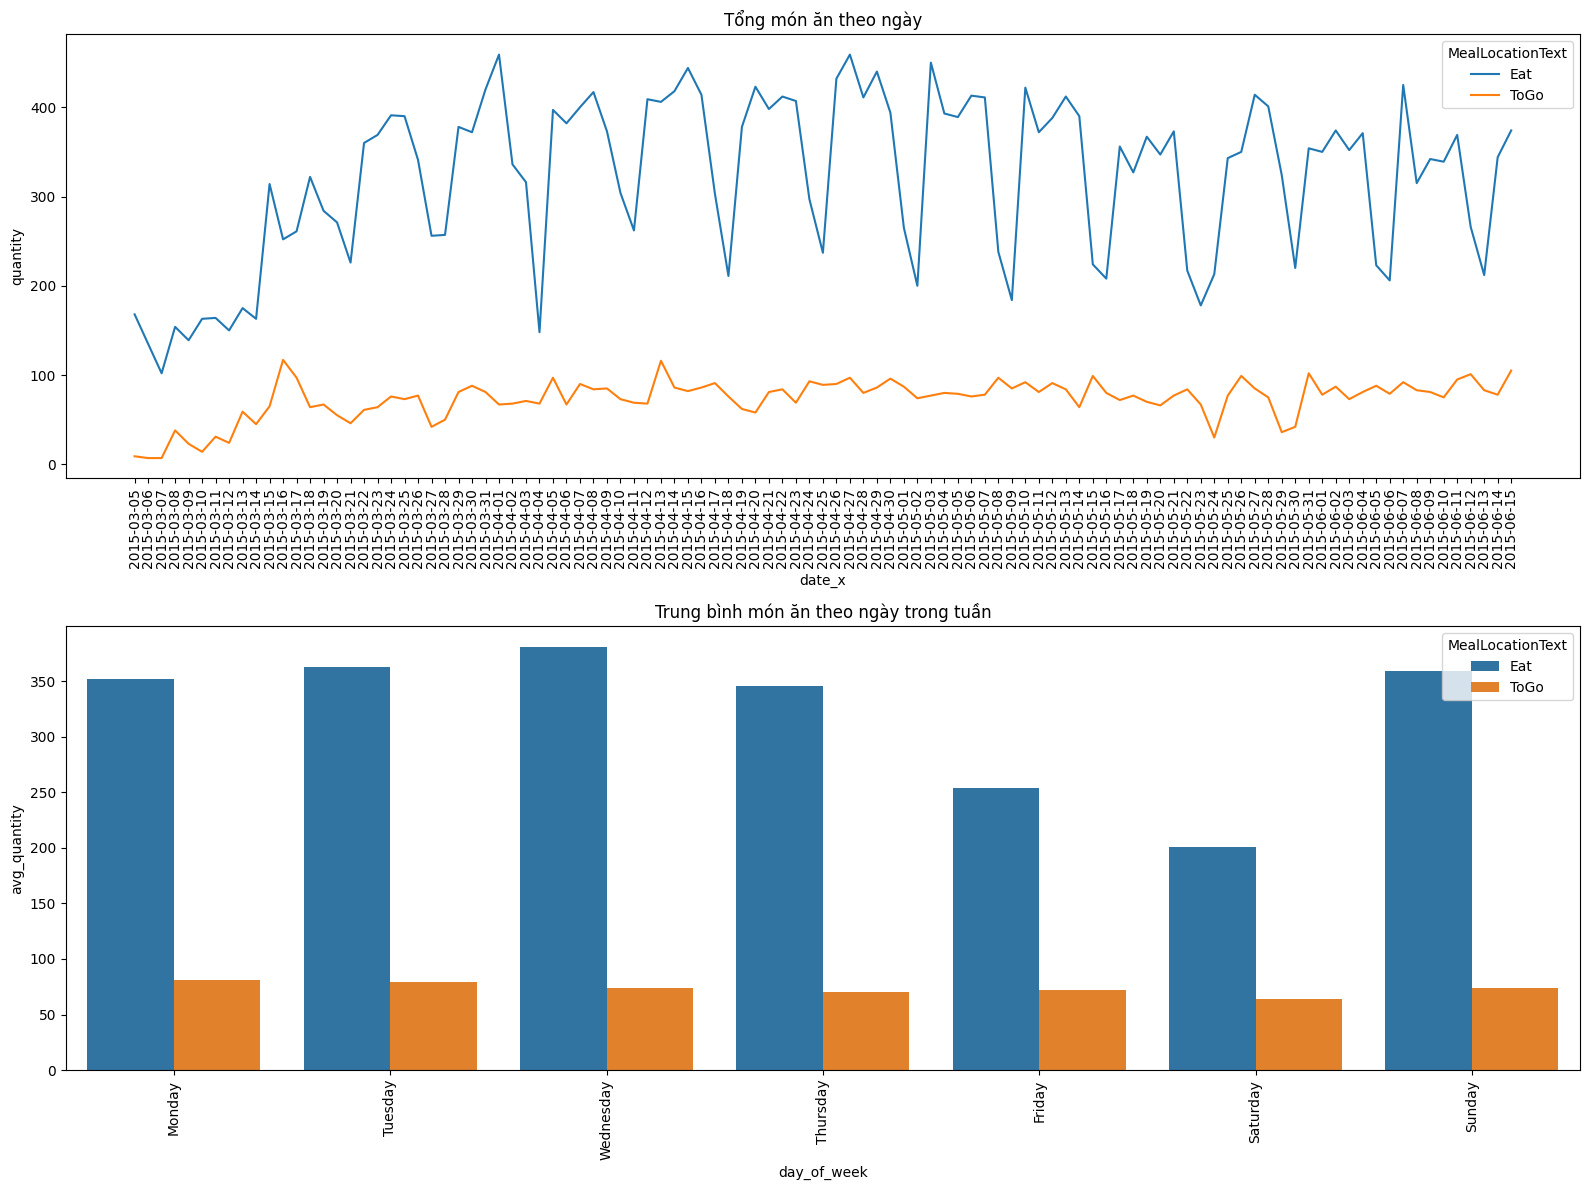

In [88]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_meallocation,
             x='date_x',
             y='quantity',
             hue='MealLocationText')
plt.xticks(rotation=90, ha='center')
plt.title("Tổng món ăn theo ngày")

plt.subplot(2, 1, 2)
sns.barplot(data=groupby_day_of_week_meallocation,
             x='day_of_week',
             y='avg_quantity',
             hue='MealLocationText',
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xticks(rotation=90, ha='center')
plt.title("Trung bình món ăn theo ngày trong tuần")

plt.tight_layout()
plt.show()

Note: Từ các phân tích số lượng đơn hàng, số lượng món ăn mỗi đơn hàng, loại hình đơn hàng đều có tính chu kỳ tăng dần từ thứ hai tới thứ 5 và giảm dần tới thứ 7 rồi tăng lại từ chủ nhật. Ngoại trừ phân tích doanh thu trung bình mỗi đơn, điều này cho thấy có thể các đơn hàng ngày thứ 7 có các món có giá trị cao trong đơn hàng.

Nextstep:
- Phân tích thêm từng cửa hàng để xem có phải là pattern chung không.
- Phân tích các món ăn được đặt nhiều ở thứ 7 so với các món ăn của các ngày trong tuần (danh mục món ăn)

### 2.2.5 Top các món ăn được đặt theo các ngày trong tuần

In [242]:
pd.options.display.float_format = '{:.2f}'.format
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week'],
      dtype='object')

#### 2.2.5.1 Kiểm tra danh mục món ăn ảnh hưởng tới doanh thu

In [243]:
# Groupby day CategoryDescription
groupby_day_CategoryDescription = df_menuitem.groupby(['date', 'day_of_week', 'CategoryDescription'], observed=True).agg(
  price=('Price', 'mean'),
  quantity=('Quantity', 'sum'),
  revenue=('SalesAmount', 'sum')
).sort_values(by='revenue', ascending=False).reset_index()

print(groupby_day_CategoryDescription['revenue'].sum())

groupby_day_CategoryDescription['Percentage'] = groupby_day_CategoryDescription['revenue'] / groupby_day_CategoryDescription['revenue'].sum() * 100

groupby_day_CategoryDescription

422607.56999999995


,date,day_of_week,CategoryDescription,price,quantity,revenue,Percentage
0,2015-05-16,Saturday,Footlong,6.61,271,39286.67,9.30
1,2015-05-23,Saturday,Footlong,6.78,216,16588.68,3.93
2,2015-03-21,Saturday,Footlong,6.75,200,4508.68,1.07
3,2015-05-23,Saturday,Chips,1.13,159,4093.37,0.97
4,2015-03-21,Saturday,6 Inch,4.41,145,2560.98,0.61
...,...,...,...,...,...,...,...
1318,2015-04-20,Monday,Other Misc,0.78,2,1.20,0.00
1319,2015-03-06,Friday,Other Misc,1.25,1,1.16,0.00
1320,2015-04-27,Monday,Other Misc,1.50,1,1.15,0.00
1321,2015-06-10,Wednesday,Other Misc,1.50,1,1.15,0.00


In [244]:
# Groupby day of week CategoryDescription
groupby_day_of_week_CategoryDescription = groupby_day_CategoryDescription.groupby(['day_of_week', 'CategoryDescription'], observed=True).agg(
  quantity=('quantity', 'sum'),
  revenue=('revenue', 'sum'),
  avg_quantity=('quantity', 'mean'),
  avg_revenue=('revenue', 'mean')
).sort_values(by='revenue', ascending=False).reset_index()

print(groupby_day_of_week_CategoryDescription['revenue'].sum())

groupby_day_of_week_CategoryDescription['Percentage'] = groupby_day_of_week_CategoryDescription['revenue'] / groupby_day_of_week_CategoryDescription['revenue'].sum() * 100

groupby_day_of_week_CategoryDescription

422607.57


,day_of_week,CategoryDescription,quantity,revenue,avg_quantity,avg_revenue,Percentage
0,Saturday,Footlong,2956,77390.27,197.07,5159.35,18.31
1,Thursday,Footlong,3708,26683.06,247.20,1778.87,6.31
2,Friday,Footlong,3472,26492.14,231.47,1766.14,6.27
3,Sunday,Footlong,3749,26070.08,249.93,1738.01,6.17
4,Monday,Footlong,3680,25904.85,245.33,1726.99,6.13
...,...,...,...,...,...,...,...
97,Friday,Hot Beverage,23,41.64,2.09,3.79,0.01
98,Monday,Hot Beverage,26,41.09,2.36,3.74,0.01
99,Sunday,Other Misc,30,41.01,2.50,3.42,0.01
100,Saturday,Hot Beverage,18,34.17,1.64,3.11,0.01


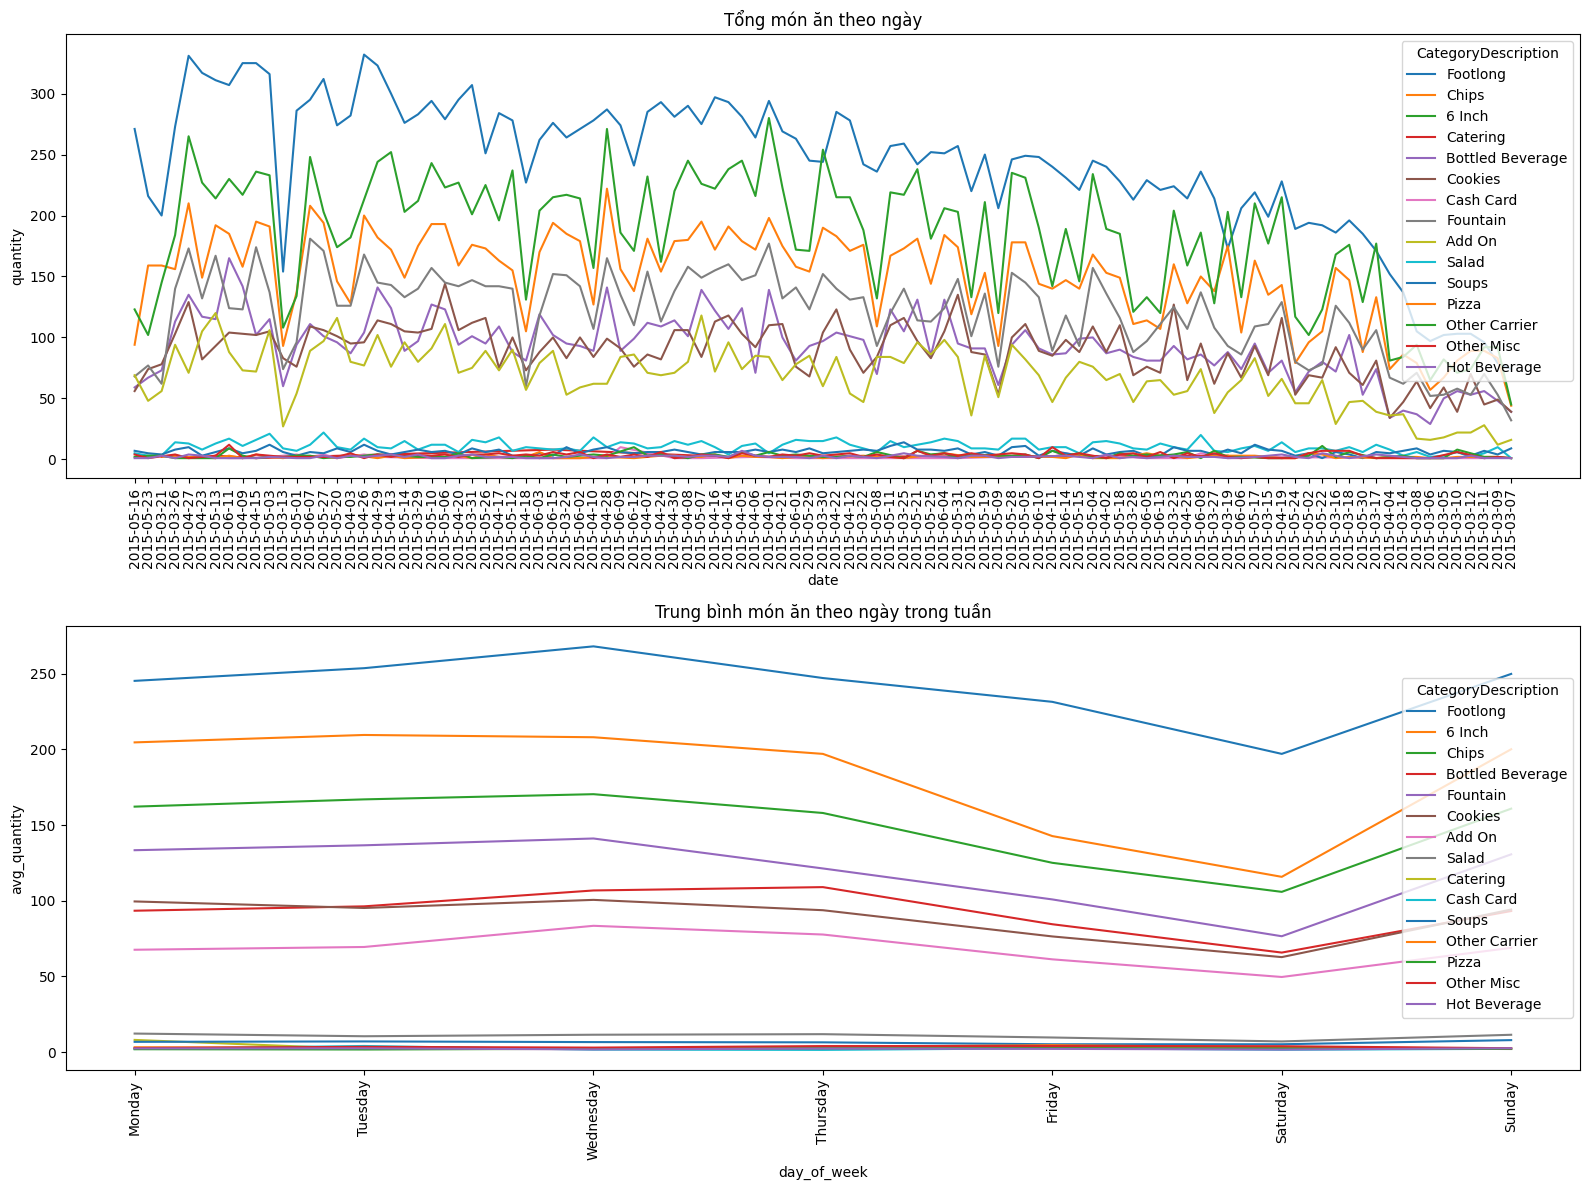

In [239]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_CategoryDescription,
             x='date',
             y='quantity',
             palette='tab10',
             hue='CategoryDescription')
plt.xticks(rotation=90, ha='center')
plt.title("Tổng món ăn theo ngày")

plt.subplot(2, 1, 2)
sns.lineplot(data=groupby_day_of_week_CategoryDescription,
             x='day_of_week',
             y='avg_quantity',
             hue='CategoryDescription',
             palette='tab10')
plt.xticks(rotation=90, ha='center')
plt.title("Trung bình món ăn theo ngày trong tuần")

plt.tight_layout()
plt.show()

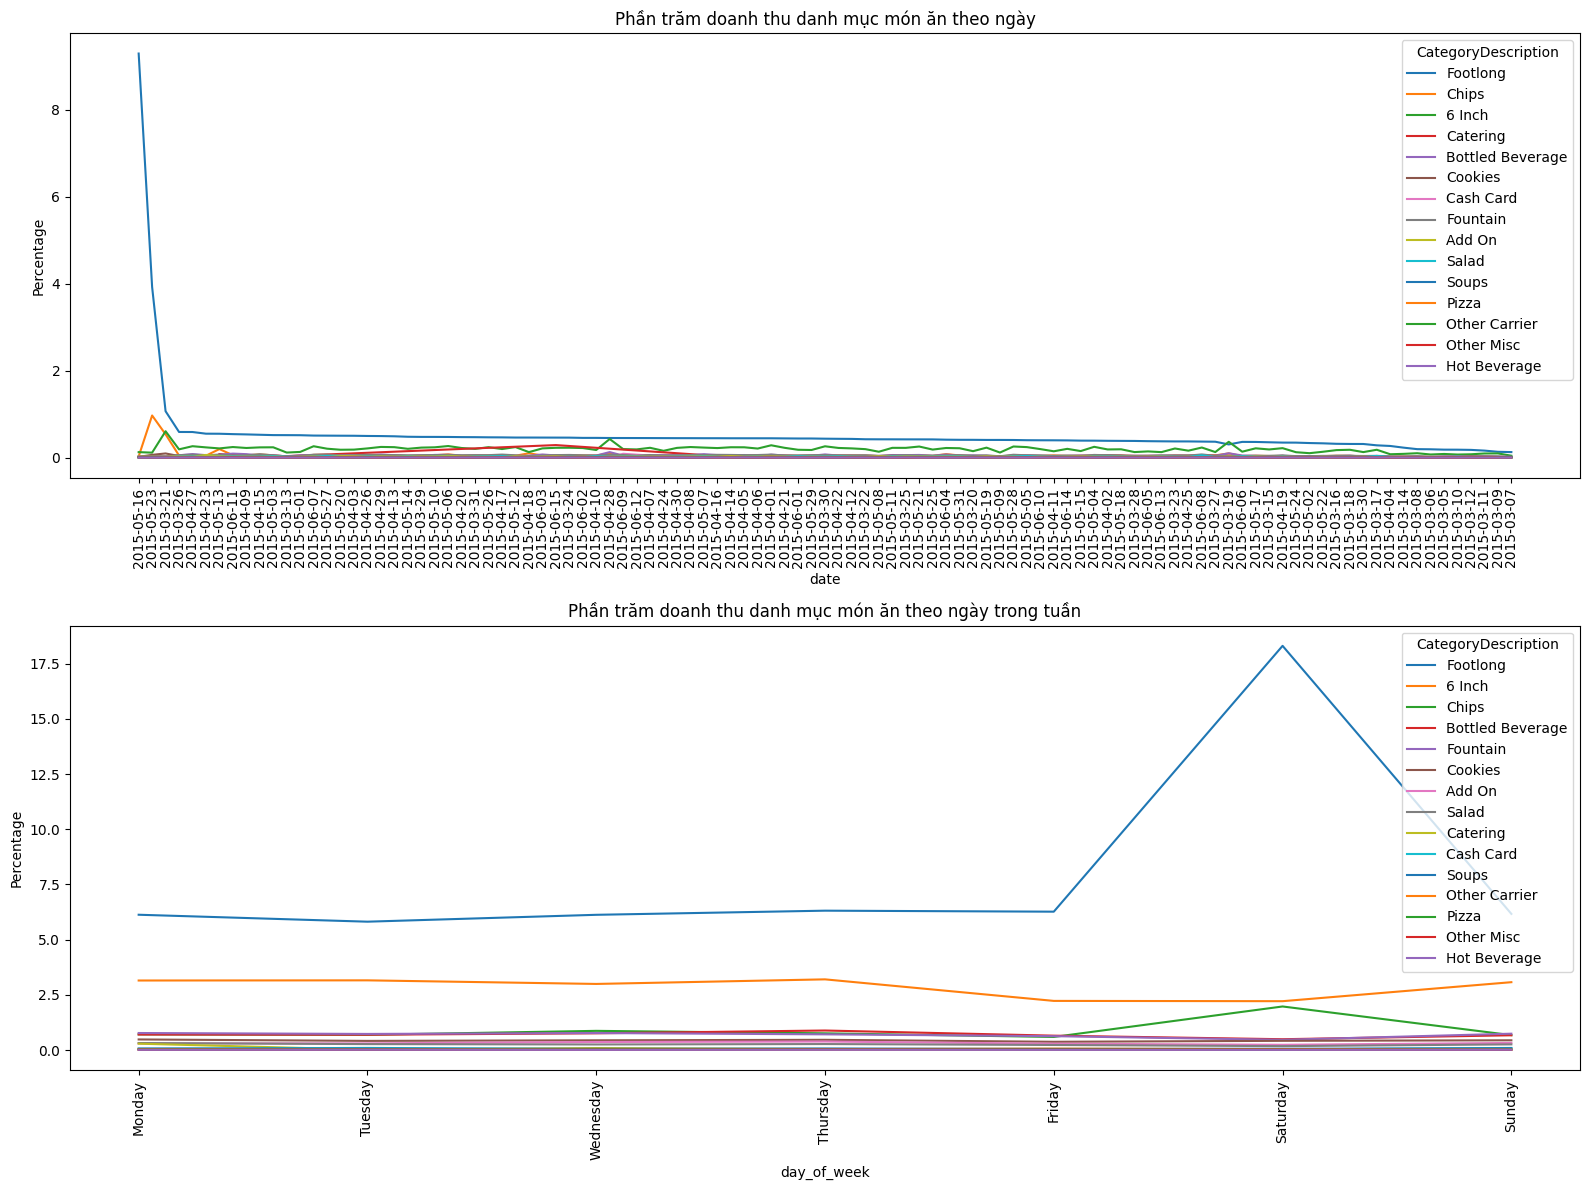

In [246]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
sns.lineplot(data=groupby_day_CategoryDescription,
             x='date',
             y='Percentage',
             palette='tab10',
             hue='CategoryDescription')
plt.xticks(rotation=90, ha='center')
plt.title("Phần trăm doanh thu danh mục món ăn theo ngày")

# plt.subplot(2, 1, 2)
# sns.barplot(data=groupby_day_of_week_CategoryDescription,
#              x='day_of_week',
#              y='Percentage',
#              hue='CategoryDescription',
#              palette='tab10',
#              order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# plt.xticks(rotation=90, ha='center')
# plt.title("Phần trăm doanh thu danh mục món ăn theo ngày trong tuần")

plt.subplot(2, 1, 2)
sns.lineplot(data=groupby_day_of_week_CategoryDescription,
             x='day_of_week',
             y='Percentage',
             hue='CategoryDescription',
             palette='tab10')
plt.xticks(rotation=90, ha='center')
plt.title("Phần trăm doanh thu danh mục món ăn theo ngày trong tuần")

plt.tight_layout()
plt.show()

Nhận xét:
- Danh mục “Footlong” có tỷ lệ đóng góp cao nhất vào doanh thu tổng thể.
- Thứ Bảy có doanh thu cao mặc dù số lượng bán ra thấp hơn, có thể là do các món có giá trị cao

Nextstep: Xem xét các món ăn có doanh thu cao trong danh mục Footlong để tối ưu hóa doanh thu.

#### 2.2.5.2 Kiểm tra món ăn có doanh thu cao trong Footlong

In [247]:
df_menuitem.columns

Index(['MD5KEY_MENUITEM', 'MD5KEY_ORDERSALE', 'CategoryDescription',
       'DepartmentDescription', 'Description', 'StoreNumber', 'TaxAmount',
       'AdjustedPrice', 'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id',
       'date', 'SalesAmount', 'day_of_week'],
      dtype='object')

In [259]:
footlong = df_menuitem[df_menuitem['CategoryDescription'] == 'Footlong']
footlong.head()

,MD5KEY_MENUITEM,MD5KEY_ORDERSALE,CategoryDescription,DepartmentDescription,Description,StoreNumber,TaxAmount,AdjustedPrice,DiscountAmount,Price,Quantity,PLU,Id,date,SalesAmount,day_of_week
0,001E0224E4EDA63D6FED96D59E0C1E76,072D3B76BE58E4553A373AF3206D2CA5,Footlong,Footlong Sub,Chickn Strips FtLong,46673,0.70,7.75,0.00,7.75,1,111000041,326,2015-03-05,7.75,Thursday
6,04420CE325EFCE905A9155CBE6EBC001,72BC117B86F77DF24BEB37C0B191B7B1,Footlong,Footlong Sub,Spicy Italian FtLong,12631,0.49,5.50,0.00,5.50,1,111000002,69,2015-03-05,5.50,Thursday
13,0C3A6213CD81B91180D6876CDFAE7A91,1E739D78994A32D295D9C6B6F2D76025,Footlong,Footlong Sub,Turkey FtLong,46673,0.67,7.40,0.35,7.75,1,111000012,12,2015-03-05,7.40,Thursday
15,0D198D7306F3E8DDBC1FA74578492647,BD5D0AA9CC8C5768029C5AE0D9A61C6D,Footlong,Footlong Sub,Subway Club FtLong,46673,0.77,8.50,0.00,8.50,1,111000017,48,2015-03-05,8.50,Thursday
17,0DAB10B5ABEBEC1BE111143391D84AC4,7DABBEA37F73D35E4A63ECCFEDAE5FC4,Footlong,Footlong Sub,Turkey Italiano FtLong,12631,0.58,6.50,0.00,6.50,1,111000731,7038,2015-03-05,6.50,Thursday


In [282]:
print("Tổng số món ăn danh mục Footlong:", footlong['Description'].nunique())

footlong_description = footlong.groupby('Description')[['Quantity', 'SalesAmount']].sum().sort_values('SalesAmount', ascending=False).reset_index()
footlong_description['Percentage'] = footlong_description['SalesAmount'] / footlong_description['SalesAmount'].sum() * 100
footlong_description['Cumsum'] = footlong_description['Percentage'].cumsum()
footlong_description


Tổng số món ăn danh mục Footlong: 61


,Description,Quantity,SalesAmount,Percentage,Cumsum
0,Turkey FtLong,2594,59445.50,25.51,25.51
1,Big Hot Pastrami FtLong,453,18949.69,8.13,33.64
2,Rst Chicken FtLong,2164,15855.91,6.80,40.45
3,Tuna FtLong,1962,14553.95,6.25,46.70
4,Chicken Teriyaki FtLong,1837,14309.09,6.14,52.84
...,...,...,...,...,...
56,TkyBcnGuac FtLong,3,26.45,0.01,99.97
57,Chicken Parm FtFbd,3,19.91,0.01,99.98
58,ChipChMltGuac FtFbd,2,17.50,0.01,99.99
59,Subway Melt FtFbd,2,15.00,0.01,100.00


##### 2.2.5.2.1 Top 5 món ăn trong danh mục footlong
5 món ăn chiếm 52% doanh thu của doanh mục

In [288]:
# Top 5 footlong_description_name
top_footlong_item = footlong_description['Description'].head(5).to_list()

In [292]:
# Lọc dữ liệu 5 món doanh thu cao
filtered_top_footlong = footlong[footlong['Description'].isin(top_footlong_item)]

In [295]:
filtered_top_footlong_groupby_day = filtered_top_footlong.groupby(['date', 'day_of_week', 'Description'], observed=True)[['Quantity', 'SalesAmount']].sum().reset_index()
filtered_top_footlong_groupby_day

,date,day_of_week,Description,Quantity,SalesAmount
0,2015-03-05,Thursday,Big Hot Pastrami FtLong,1,8.25
1,2015-03-05,Thursday,Chicken Teriyaki FtLong,9,67.75
2,2015-03-05,Thursday,Rst Chicken FtLong,5,35.81
3,2015-03-05,Thursday,Tuna FtLong,15,117.34
4,2015-03-05,Thursday,Turkey FtLong,8,45.91
...,...,...,...,...,...
508,2015-06-15,Monday,Big Hot Pastrami FtLong,7,58.20
509,2015-06-15,Monday,Chicken Teriyaki FtLong,25,204.43
510,2015-06-15,Monday,Rst Chicken FtLong,21,143.26
511,2015-06-15,Monday,Tuna FtLong,23,170.47


In [302]:
filtered_top_footlong_groupby_day_of_week = filtered_top_footlong_groupby_day.groupby(['day_of_week', 'Description'],
                                                                                      observed=True)[['Quantity', 'SalesAmount']].sum().sort_values('SalesAmount', ascending=False).reset_index()
filtered_top_footlong_groupby_day_of_week.head()

,day_of_week,Description,Quantity,SalesAmount
0,Saturday,Turkey FtLong,391,43092.10
1,Saturday,Big Hot Pastrami FtLong,83,15714.87
2,Friday,Rst Chicken FtLong,385,3272.54
3,Thursday,Turkey FtLong,394,3201.01
4,Sunday,Turkey FtLong,404,2799.56


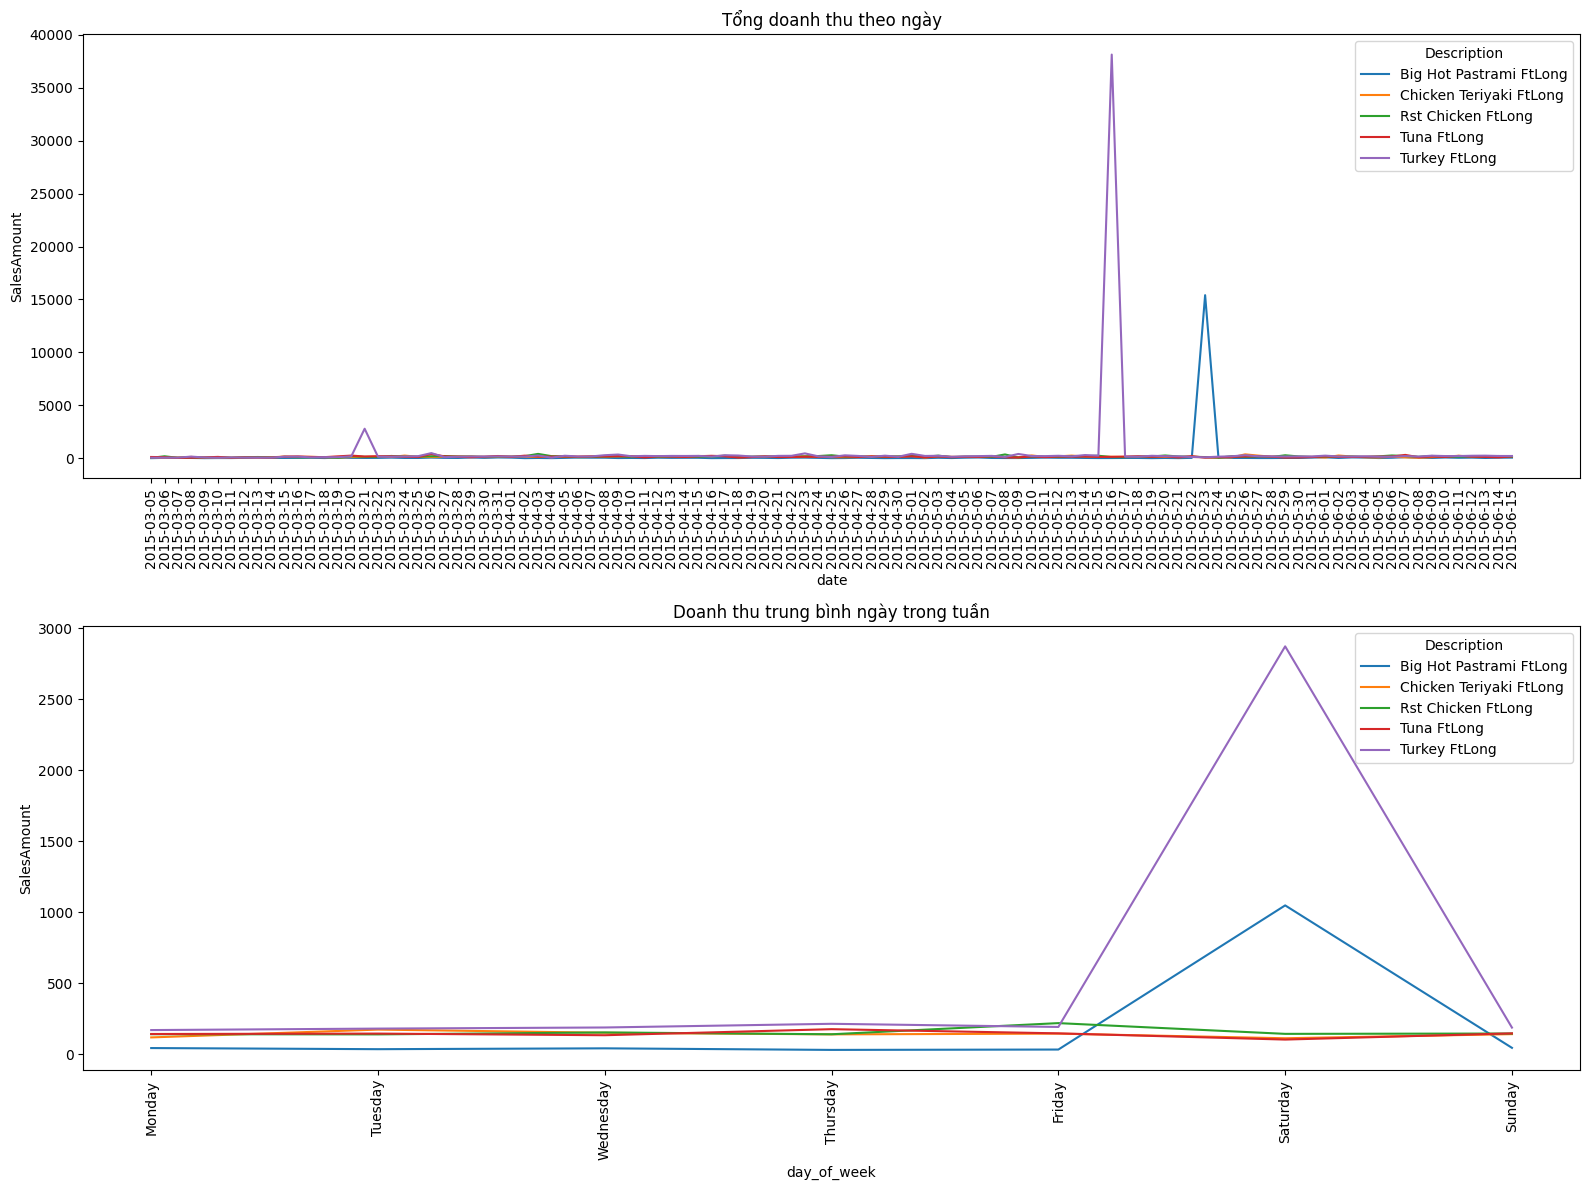

In [300]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
sns.lineplot(data=filtered_top_footlong_groupby_day,
             x='date',
             y='SalesAmount',
             palette='tab10',
             hue='Description')
plt.xticks(rotation=90, ha='center')
plt.title("Tổng doanh thu theo ngày")

plt.subplot(2, 1, 2)
sns.lineplot(data=filtered_top_footlong_groupby_day_of_week,
             x='day_of_week',
             y='SalesAmount',
             hue='Description',
             palette='tab10')
plt.xticks(rotation=90, ha='center')
plt.title("Doanh thu trung bình ngày trong tuần")

plt.tight_layout()
plt.show()

Nhận xét:
- Turkey FtLong đem lại doanh thu cao

# 3. So sánh doanh thu từng cửa hàng
So sánh doanh thu của từng cửa hàng để xác định cửa hàng có doanh thu cao nhất và thấp nhất

## 3.1 Tổng

In [303]:
df_menuitem.groupby('StoreNumber').agg(revenue=('SalesAmount', 'sum'))

,revenue
StoreNumber,
4904,179129.39
12631,100888.28
20974,77242.96
46673,65346.94


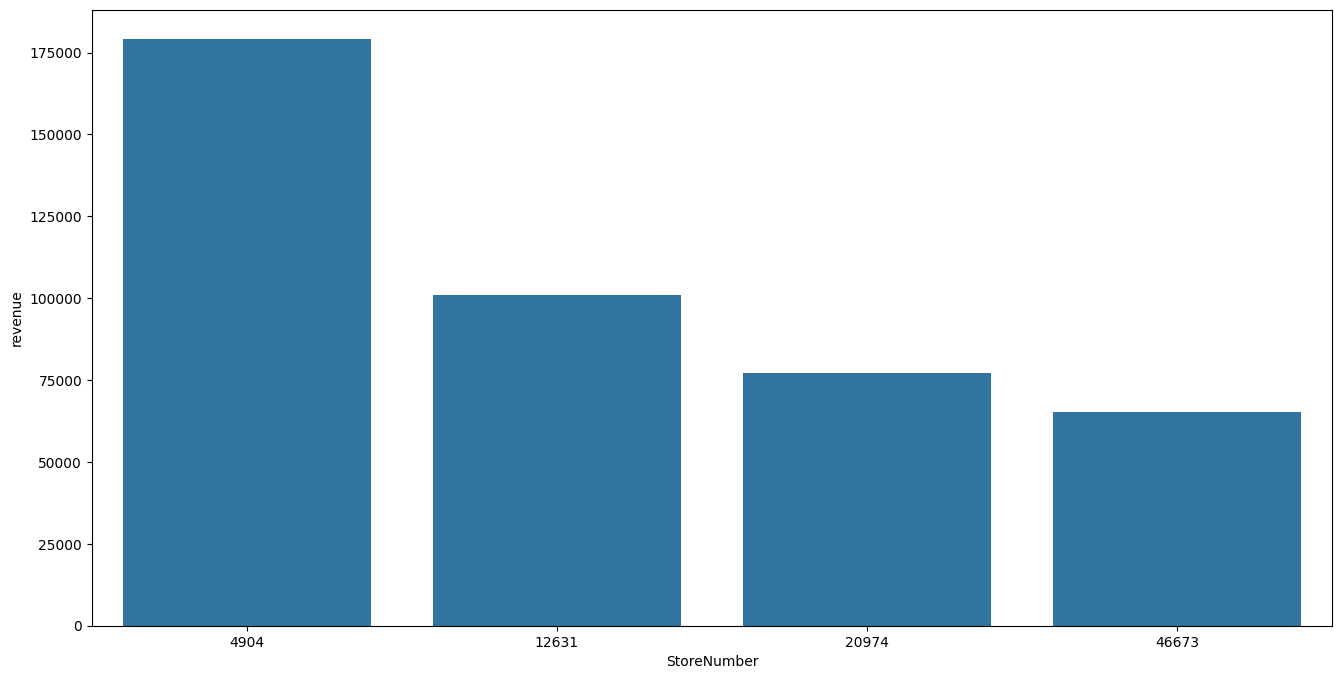

In [304]:
plt.figure(figsize=(16, 8))

sns.barplot(data=df_menuitem.groupby('StoreNumber').agg(revenue=('SalesAmount', 'sum')).reset_index(),
            x='StoreNumber',
            y='revenue')

plt.show()

## 3.2 Non-outliers

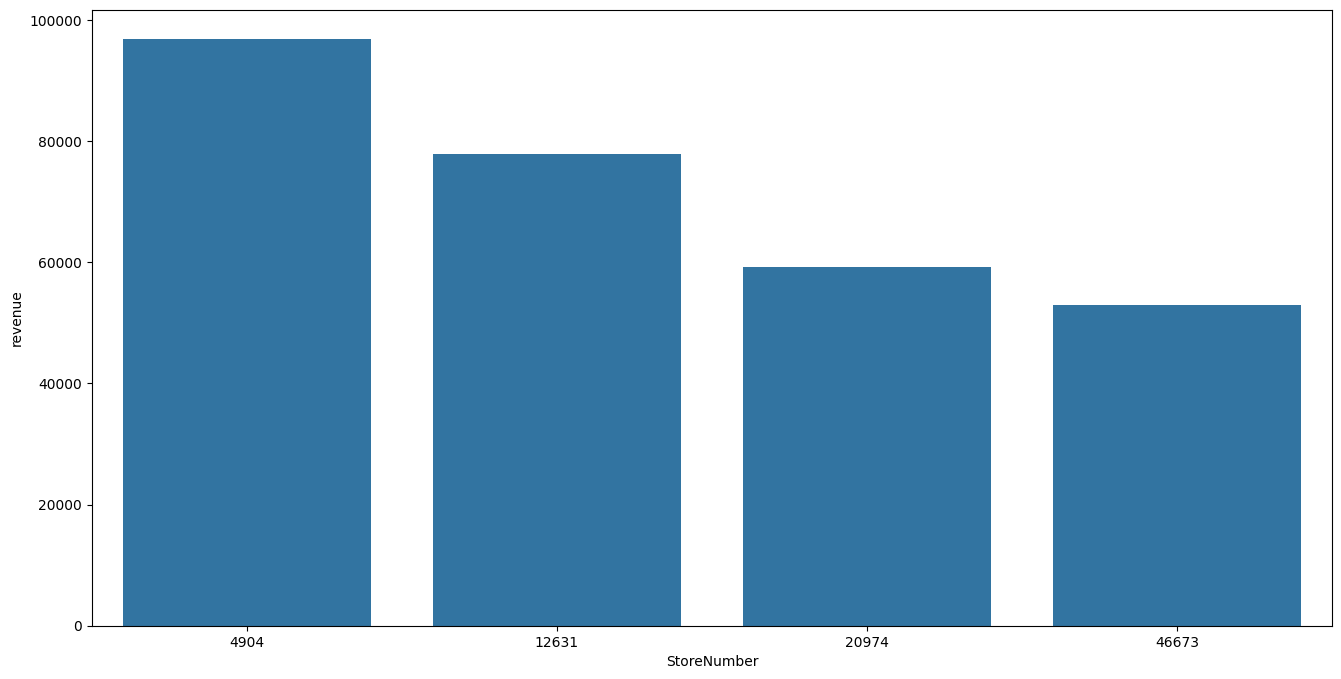

In [305]:
plt.figure(figsize=(16, 8))

sns.barplot(data=non_outliers_quantity.groupby('StoreNumber').agg(revenue=('SalesAmount', 'sum')).reset_index(),
            x='StoreNumber',
            y='revenue')

plt.show()

# 4. Phân tích tác động của giảm giá
Phân tích tác động của việc giảm giá lên số lượng bán ra và doanh thu.

## 4.1 Merge ordersale và menuitem
Mục tiêu: kiểm tra đơn hàng giảm giá. Các yếu tố thời gian liên quan tới chương trình giảm giá như thời gian trước và sau áp dụng giảm giá

In [306]:
merged_ordersale_menuitem = pd.merge(df_ordersale, df_menuitem, on="MD5KEY_ORDERSALE", how="inner")

In [307]:
merged_ordersale_menuitem.columns

Index(['MD5KEY_ORDERSALE', 'ChangeReceived', 'OrderNumber', 'TaxAmount_x',
       'MealLocation', 'TransactionId', 'StoreNumber_x', 'date_x',
       'MD5KEY_MENUITEM', 'CategoryDescription', 'DepartmentDescription',
       'Description', 'StoreNumber_y', 'TaxAmount_y', 'AdjustedPrice',
       'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id', 'date_y',
       'SalesAmount', 'day_of_week'],
      dtype='object')

In [308]:
print(merged_ordersale_menuitem['MD5KEY_ORDERSALE'].nunique())
print(merged_ordersale_menuitem['SalesAmount'].sum())

40621
422607.57


## 4.2 Kiểm tra doanh thu có giảm giá và không giảm giá

### 4.2.1 Kiểm tra tác động theo ngày

In [309]:
print(merged_ordersale_menuitem[merged_ordersale_menuitem['DiscountAmount'] == 0]['SalesAmount'].sum())
print(merged_ordersale_menuitem[merged_ordersale_menuitem['DiscountAmount'] > 0]['SalesAmount'].sum())

290898.46
131709.11


In [310]:
merged_groupby_day = merged_ordersale_menuitem.groupby('date_x').agg(
  total_discount=('DiscountAmount', 'sum'),
  total_salesamount=('SalesAmount', 'sum')).reset_index()

merged_groupby_day

,date_x,total_discount,total_salesamount
0,2015-03-05,76.06,1558.79
1,2015-03-06,54.82,1428.28
2,2015-03-07,37.69,1035.61
3,2015-03-08,84.10,1774.18
4,2015-03-09,77.35,1440.49
...,...,...,...
98,2015-06-11,155.51,4601.22
99,2015-06-12,157.24,3675.96
100,2015-06-13,107.73,2965.03
101,2015-06-14,124.58,3491.54


In [311]:
print(merged_groupby_day[merged_groupby_day['total_discount'] == 0]['total_salesamount'].sum())
print(merged_groupby_day[merged_groupby_day['total_discount'] > 0]['total_salesamount'].sum())

0.0
422607.56999999995


Nhận xét: tất cả các ngày đều có giảm giá

### 4.2.2 Kiểm tra theo số lượng trung bình item mỗi order

In [312]:
merged_groupby_order = merged_ordersale_menuitem.groupby('MD5KEY_ORDERSALE').agg(
  total_items=('MD5KEY_MENUITEM', 'count'),
  total_quantity=('Quantity', 'sum'),
  total_discount=('DiscountAmount', 'sum'),
  total_salesamount=('SalesAmount', 'sum')
).reset_index()

merged_groupby_order

,MD5KEY_ORDERSALE,total_items,total_quantity,total_discount,total_salesamount
0,00040FB2079EE37A1A3347134FDA1222,1,1,0.75,6.00
1,000487D84122ECFC7C2B0681D7847D07,2,4,1.50,28.40
2,0006541E961609F6EA9B93AF996791FA,1,1,0.00,4.25
3,0007198A6EA115A618FB1F7A47DA5A94,1,1,0.75,6.00
4,0009AF6BC70525EA7865AB795C651219,2,2,7.30,0.00
...,...,...,...,...,...
40616,FFF4B340CBD214BD2A0C12944DD6FC4C,1,1,0.00,5.50
40617,FFF4B38DC800DE5784EC2F27909AB4B9,3,3,0.00,9.25
40618,FFF9C0AFD57C0B07E3ADE021C41BC222,1,1,0.00,6.75
40619,FFFB7296078113301047E98795ED0836,3,3,1.55,6.00


In [313]:
print("Doanh thu không giảm giá:", merged_groupby_order[merged_groupby_order['total_discount'] == 0]['total_salesamount'].sum())
print("Doanh thu có giảm giá", merged_groupby_order[merged_groupby_order['total_discount'] > 0]['total_salesamount'].sum())
print("Số lượng món trong mỗi order không giảm giá:", merged_groupby_order[merged_groupby_order['total_discount'] == 0]['total_items'].sum())
print("Số lượng món trong mỗi order có giảm giá:",merged_groupby_order[merged_groupby_order['total_discount'] > 0]['total_items'].sum())

Doanh thu không giảm giá: 224220.66999999998
Doanh thu có giảm giá 198386.90000000002
Số lượng món trong mỗi order không giảm giá: 44791
Số lượng món trong mỗi order có giảm giá: 46629


### 4.3 Đơn hàng có giảm giá và không giảm giá

In [314]:
merged_ordersale_menuitem.columns

Index(['MD5KEY_ORDERSALE', 'ChangeReceived', 'OrderNumber', 'TaxAmount_x',
       'MealLocation', 'TransactionId', 'StoreNumber_x', 'date_x',
       'MD5KEY_MENUITEM', 'CategoryDescription', 'DepartmentDescription',
       'Description', 'StoreNumber_y', 'TaxAmount_y', 'AdjustedPrice',
       'DiscountAmount', 'Price', 'Quantity', 'PLU', 'Id', 'date_y',
       'SalesAmount', 'day_of_week'],
      dtype='object')

In [315]:
# Groupby order
order_group = merged_ordersale_menuitem.groupby('MD5KEY_ORDERSALE').agg(
  Discounted=("DiscountAmount", "sum"),
  TotalSaleAmount=('SalesAmount', 'sum')).reset_index()

print("Order discount:", order_group[order_group['Discounted'] > 0]['MD5KEY_ORDERSALE'].count())
print("Order non discount:", order_group[order_group['Discounted'] == 0]['MD5KEY_ORDERSALE'].count())
print(order_group[order_group['Discounted'] > 0]['MD5KEY_ORDERSALE'].count() + order_group[order_group['Discounted'] == 0]['MD5KEY_ORDERSALE'].count())

print("Doanh thu:", merged_ordersale_menuitem['SalesAmount'].sum())
print("Doanh thu:", df_menuitem['SalesAmount'].sum())

print(merged_ordersale_menuitem['MD5KEY_ORDERSALE'].nunique())
print(order_group['MD5KEY_ORDERSALE'].nunique())
print(order_group['TotalSaleAmount'].sum())

order_group

Order discount: 13837
Order non discount: 26784
40621
Doanh thu: 422607.57
Doanh thu: 422607.57
40621
40621
422607.57000000007


,MD5KEY_ORDERSALE,Discounted,TotalSaleAmount
0,00040FB2079EE37A1A3347134FDA1222,0.75,6.00
1,000487D84122ECFC7C2B0681D7847D07,1.50,28.40
2,0006541E961609F6EA9B93AF996791FA,0.00,4.25
3,0007198A6EA115A618FB1F7A47DA5A94,0.75,6.00
4,0009AF6BC70525EA7865AB795C651219,7.30,0.00
...,...,...,...
40616,FFF4B340CBD214BD2A0C12944DD6FC4C,0.00,5.50
40617,FFF4B38DC800DE5784EC2F27909AB4B9,0.00,9.25
40618,FFF9C0AFD57C0B07E3ADE021C41BC222,0.00,6.75
40619,FFFB7296078113301047E98795ED0836,1.55,6.00


#### 4.3.1 Lọc đơn hàng có giảm giá và không giảm giá

In [316]:
# Get index of order discount and non discount
discount_list = order_group[order_group['Discounted'] > 0]['MD5KEY_ORDERSALE'].tolist()
non_discount_list = order_group[order_group['Discounted'] == 0]['MD5KEY_ORDERSALE'].tolist()

# Filter discount and non discount by index
discount_order = merged_ordersale_menuitem[merged_ordersale_menuitem['MD5KEY_ORDERSALE'].isin(discount_list)]
non_discount_order = merged_ordersale_menuitem[merged_ordersale_menuitem['MD5KEY_ORDERSALE'].isin(non_discount_list)]

print("Số đơn hàng discount:", discount_order['MD5KEY_ORDERSALE'].nunique())
print("Số đơn hàng không discount:", non_discount_order['MD5KEY_ORDERSALE'].nunique())
print("Tổng đơn hàng:", discount_order['MD5KEY_ORDERSALE'].nunique() + non_discount_order['MD5KEY_ORDERSALE'].nunique())

print("Doanh thu discount:", discount_order['SalesAmount'].sum())
print("Doanh thu non discount:", non_discount_order['SalesAmount'].sum())
print("Tổng doanh thu:", discount_order['SalesAmount'].sum() + non_discount_order['SalesAmount'].sum())
print(order_group['TotalSaleAmount'].sum())


Số đơn hàng discount: 13837
Số đơn hàng không discount: 26784
Tổng đơn hàng: 40621
Doanh thu discount: 198386.89999999997
Doanh thu non discount: 224220.67
Tổng doanh thu: 422607.56999999995
422607.57000000007


#### 4.3.2 Đơn hàng có giảm giá

##### 4.3.2.1 Đếm số lượng món giảm giá

In [317]:

# Count the number of discounted items in each order
count_item_discount = discount_order[discount_order['DiscountAmount'] > 0]
order_discount_summary_item = count_item_discount.groupby('MD5KEY_ORDERSALE').agg(quantity_item_discount=('DiscountAmount', 'count')).reset_index()
order_discount_summary_item.head()

,MD5KEY_ORDERSALE,quantity_item_discount
0,00040FB2079EE37A1A3347134FDA1222,1
1,000487D84122ECFC7C2B0681D7847D07,1
2,0007198A6EA115A618FB1F7A47DA5A94,1
3,0009AF6BC70525EA7865AB795C651219,2
4,000F687919E50697C501391931A4A885,3


##### 4.3.2.2 Group đơn hàng

In [320]:
#Group by order
discount_order_group_1 = discount_order.groupby(['MD5KEY_ORDERSALE', 'StoreNumber_x', 'date_x', 'day_of_week'], observed=True).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum'),
  DiscountAmount=('DiscountAmount', 'sum'),
  TaxAmount=('TaxAmount_y', 'sum'),
  MealLocation=('MealLocation', 'sum')
).reset_index()

In [332]:
discount_order_group_1['MealLocation'] = discount_order_group_1['MealLocation'].apply(lambda x: 1 if x > 0 else 0)
discount_order_group_1['MealLocation'].unique()

array([0, 1])

##### 4.3.2.3 Merge đơn hàng và số lượng món giảm giá

In [333]:
# Merge discount_order_groupby
merged_discount_order_groupby = pd.merge(discount_order_group_1, order_discount_summary_item, on='MD5KEY_ORDERSALE', how='left')
merged_discount_order_groupby.head()

,MD5KEY_ORDERSALE,StoreNumber_x,date_x,day_of_week,Quantity,SalesAmount,DiscountAmount,TaxAmount,MealLocation,quantity_item_discount
0,00040FB2079EE37A1A3347134FDA1222,12631,2015-04-03,Friday,1,6.00,0.75,0.53,0,1
1,000487D84122ECFC7C2B0681D7847D07,12631,2015-04-03,Friday,4,28.40,1.50,1.26,0,1
2,0007198A6EA115A618FB1F7A47DA5A94,12631,2015-04-16,Thursday,1,6.00,0.75,0.53,0,1
3,0009AF6BC70525EA7865AB795C651219,12631,2015-04-22,Wednesday,2,0.00,7.30,0.00,0,2
4,000F687919E50697C501391931A4A885,12631,2015-06-03,Wednesday,3,6.75,0.40,0.60,0,3


In [334]:
# Kiểm tra số lương món kiểm giá có bị tính sai không
merged_discount_order_groupby['check_quantity_item_discount'] = merged_discount_order_groupby['Quantity'] - merged_discount_order_groupby['quantity_item_discount']
print(merged_discount_order_groupby['check_quantity_item_discount'].unique())

[  0   3   1   2   5   4   6   9   8   7  13  14  10  37  12  79 109  75
  15  16  72]


In [335]:
# Số đơn hàng ăn tại chỗ và đơn hàng mang đi
mealLocation_group = merged_discount_order_groupby.groupby('MealLocation').agg(
  total_order=('MealLocation', 'count'),
  total_revenue=('SalesAmount', 'sum')).reset_index()
mealLocation_group

,MealLocation,total_order,total_revenue
0,0,11727,179969.95
1,1,2110,18416.95


In [336]:
mealLocation_group['Percentage_order'] = mealLocation_group['total_order'] / merged_discount_order_groupby.shape[0] * 100
mealLocation_group['Percentage_revenue'] = mealLocation_group['total_revenue'] / merged_discount_order_groupby['SalesAmount'].sum() * 100
mealLocation_group['MealLocation_text'] = mealLocation_group['MealLocation'].apply(lambda x: 'Ăn tại chỗ' if x==0 else 'Mang đi')
mealLocation_group

,MealLocation,total_order,total_revenue,Percentage_order,Percentage_revenue,MealLocation_text
0,0,11727,179969.95,84.75,90.72,Ăn tại chỗ
1,1,2110,18416.95,15.25,9.28,Mang đi


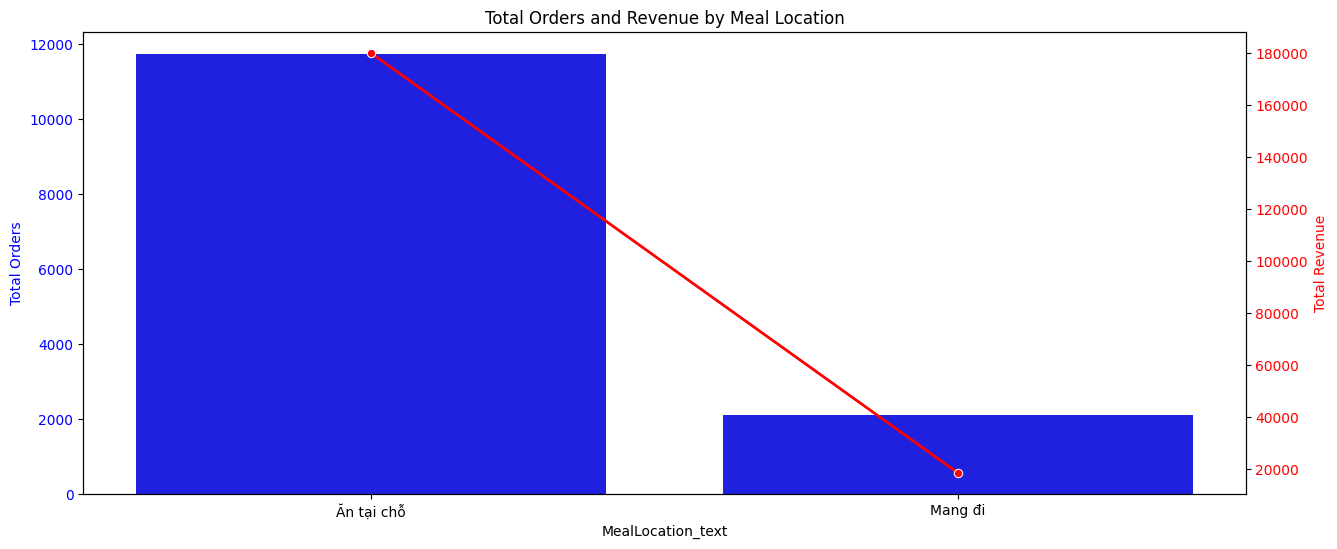

In [337]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Vẽ biểu đồ thanh cho total_order
sns.barplot(data=mealLocation_group, x='MealLocation_text', y='total_order', ax=ax1, color='b')
ax1.set_ylabel('Total Orders', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Tạo trục y thứ hai để vẽ biểu đồ đường cho total_revenue
ax2 = ax1.twinx()
sns.lineplot(data=mealLocation_group, x='MealLocation_text', y='total_revenue', ax=ax2, color='r', marker='o', linewidth=2)
ax2.set_ylabel('Total Revenue', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Thiết lập tiêu đề và hiển thị biểu đồ
plt.title('Total Orders and Revenue by Meal Location')
plt.show()

##### 4.3.2.4 Phân tích cơ bản

In [338]:
merged_discount_order_groupby.select_dtypes(include="number").describe()

,StoreNumber_x,Quantity,SalesAmount,DiscountAmount,TaxAmount,MealLocation,quantity_item_discount,check_quantity_item_discount
count,13837.00,13837.00,13837.00,13837.00,13837.00,13837.00,13837.00,13837.00
mean,19135.03,3.64,14.34,1.33,0.72,0.15,2.76,0.88
std,15297.77,2.31,363.30,1.60,0.69,0.36,1.13,1.97
min,4904.00,1.00,0.00,0.05,0.00,0.00,1.00,0.00
25%,4904.00,3.00,6.00,0.30,0.53,0.00,3.00,0.00
50%,12631.00,3.00,8.10,0.75,0.66,0.00,3.00,0.00
75%,20974.00,4.00,11.00,1.70,0.91,0.00,3.00,1.00
max,46673.00,112.00,37971.08,38.50,43.23,1.00,24.00,109.00


##### 4.3.2.5 Tính các chỉ số trung bình mỗi đơn hàng
- Doanh thu
- Số lượng món
- Số lượng món giảm giá

In [339]:
print("Tổng doanh thu:", merged_discount_order_groupby['SalesAmount'].sum())
print("Doanh thu trung bình mỗi đơn hàng:", merged_discount_order_groupby['SalesAmount'].mean())
print("Trung bình giảm giá mỗi đơn hàng:", merged_discount_order_groupby['DiscountAmount'].mean())
print("Trung bình số lượng món mỗi đơn hàng:", merged_discount_order_groupby['Quantity'].mean())
print("Trung bình số lượng món giảm giá mỗi đơn hàng:", merged_discount_order_groupby['quantity_item_discount'].mean())


Tổng doanh thu: 198386.90000000002
Doanh thu trung bình mỗi đơn hàng: 14.337421406374215
Trung bình giảm giá mỗi đơn hàng: 1.3266611259666112
Trung bình số lượng món mỗi đơn hàng: 3.6380718363807185
Trung bình số lượng món giảm giá mỗi đơn hàng: 2.759124087591241


##### 4.3.2.6 Visualization

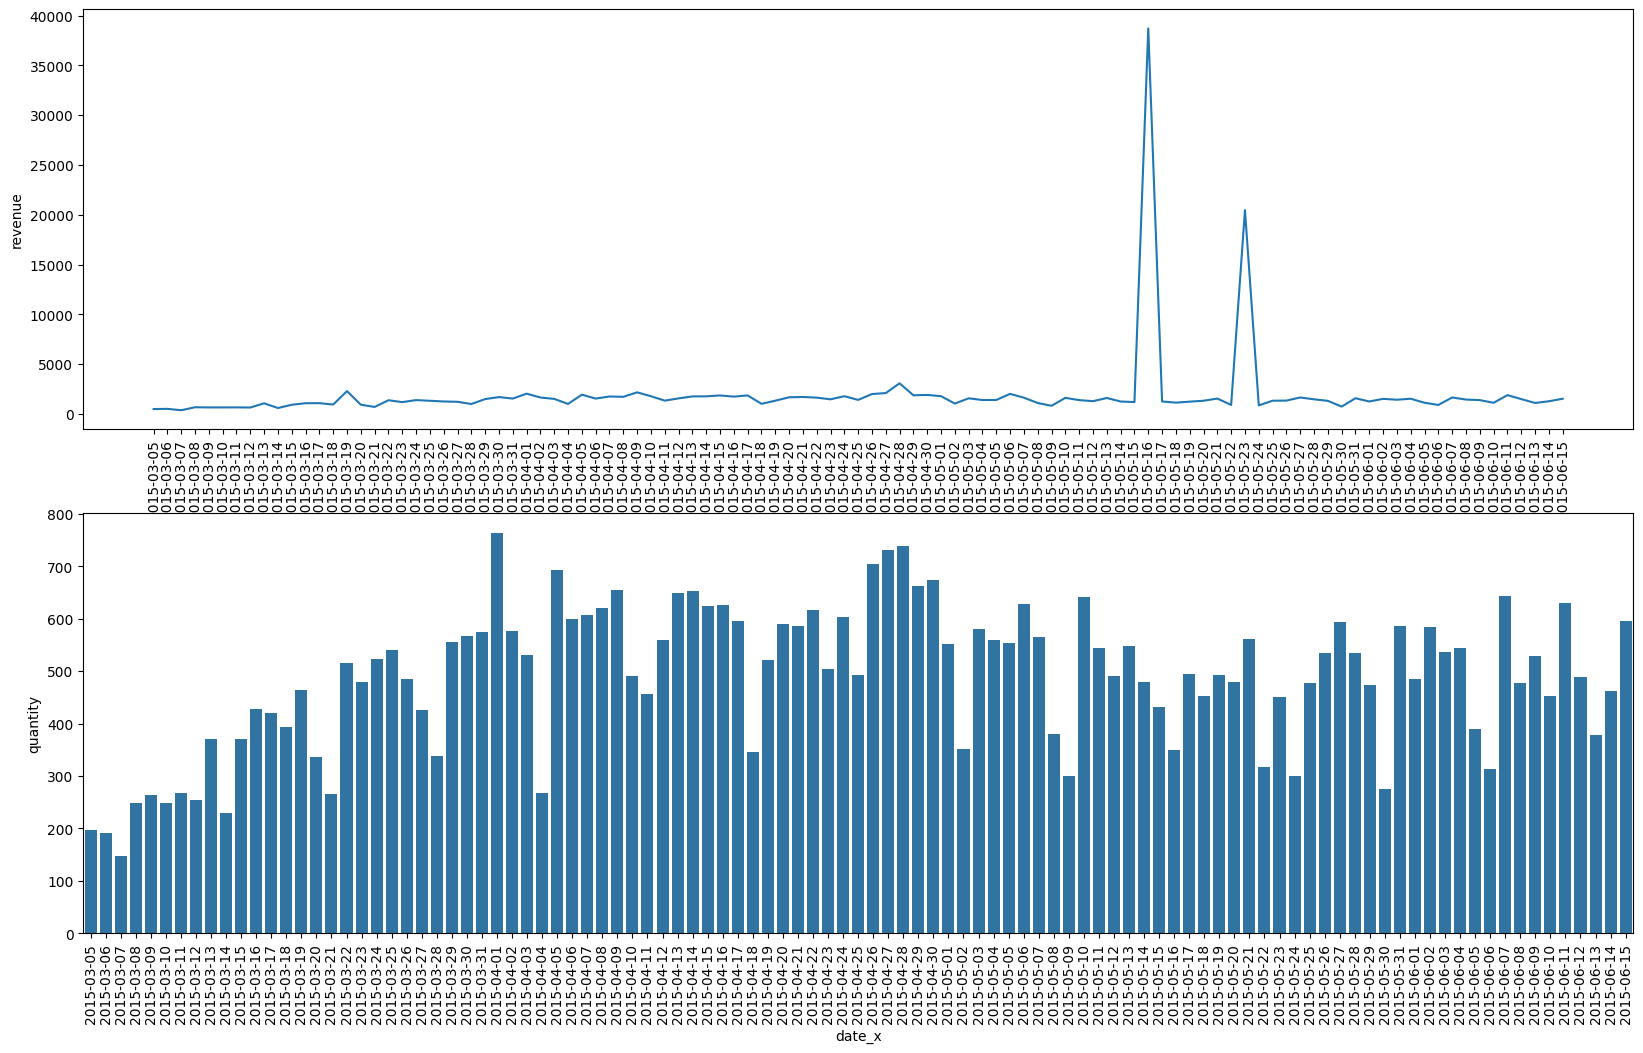

In [340]:
plt.figure(figsize=(20, 12))

plt.subplot(2,1,1)
sns.lineplot(data=merged_discount_order_groupby.groupby('date_x').agg(revenue=('SalesAmount', 'sum')),
             x='date_x',
             y='revenue',)
plt.xticks(rotation=90, ha='center')

plt.subplot(2,1,2)
sns.barplot(data=merged_discount_order_groupby.groupby('date_x').agg(quantity=('Quantity', 'sum')),
             x='date_x',
             y='quantity')
plt.xticks(rotation=90, ha='center')

plt.tight_layout
plt.show()

In [341]:
print(merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-15"]['Quantity'].sum(),
      merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-15"]['SalesAmount'].sum())
print(merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-16"]['Quantity'].sum(),
      merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-16"]['SalesAmount'].sum())
print(merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-17"]['Quantity'].sum(),
      merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-17"]['SalesAmount'].sum())
print()

print(merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-22"]['Quantity'].sum(),
      merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-22"]['SalesAmount'].sum())
print(merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-23"]['Quantity'].sum(),
      merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-23"]['SalesAmount'].sum())
print(merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-24"]['Quantity'].sum(),
      merged_discount_order_groupby[merged_discount_order_groupby['date_x'] == "2015-05-24"]['SalesAmount'].sum())

431 1192.92
350 38707.91
495 1254.46

318 903.91
451 20465.120000000006
301 856.8100000000001


##### 4.3.2.7 kiểm tra món ăn 2 ngày 16 - 23

In [342]:
discount_order[(discount_order['date_x'] == "2015-05-16")]

,MD5KEY_ORDERSALE,ChangeReceived,OrderNumber,TaxAmount_x,MealLocation,TransactionId,StoreNumber_x,date_x,MD5KEY_MENUITEM,CategoryDescription,...,TaxAmount_y,AdjustedPrice,DiscountAmount,Price,Quantity,PLU,Id,date_y,SalesAmount,day_of_week
63493,0368302B1357712075FB833657E61D1C,0.25,11495,0.00,1,11495,4904,2015-05-16,CEB9C4A6C4C8CC5B1B31467ECAD34C1B,Footlong,...,0.00,5.75,1.00,6.75,1,111000006,74,2015-05-16,5.75,Saturday
63506,0BD295387D4D4A253C7C2EDC32921493,0.00,8717,0.87,0,8718,12631,2015-05-16,3E03123AB392BAC39A9CE34BB27BA1A2,Fountain,...,0.14,1.57,0.03,1.60,1,212000126,280,2015-05-16,1.57,Saturday
63507,0BD295387D4D4A253C7C2EDC32921493,0.00,8717,0.87,0,8718,12631,2015-05-16,54F3D37FB2BBDBDFF6D394405893A5F1,Footlong,...,0.63,7.10,0.15,7.25,1,111000021,38,2015-05-16,7.10,Saturday
63508,0BD295387D4D4A253C7C2EDC32921493,0.00,8717,0.87,0,8718,12631,2015-05-16,558716098216858B069B9DEC01B85216,Chips,...,0.10,1.08,0.02,1.10,1,311000100,277,2015-05-16,1.08,Saturday
63519,0FF6A54C2B033BD764FB5FC54397AC16,0.00,8697,0.83,0,8698,12631,2015-05-16,4010FC07C2DBD92BEBF48ADC0A984386,Bottled Beverage,...,0.15,1.73,0.07,1.80,1,221000133,279,2015-05-16,1.73,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64099,F04AFC3FEFCC7865D47F665371F55BE5,0.00,5500,0.59,0,5500,20974,2015-05-16,F4D75B56F82E2DE6FE93954A6ABA0D9D,6 Inch,...,0.36,4.31,0.19,4.50,1,121000731,7040,2015-05-16,4.31,Saturday
64106,F7CBAD56B76AA942F525CEE4EA97FF06,0.00,8681,0.29,0,8682,12631,2015-05-16,E15FC30219173D73DB7D4E6807901A96,6 Inch,...,0.28,3.19,0.56,3.75,1,121000003,59,2015-05-16,3.19,Saturday
64107,F843D481B38429B124F8A91C15DB1CD1,0.00,5173,0.95,0,5173,46673,2015-05-16,9860A94A9E2B1CC1EFD352C3DAC6E33E,Chips,...,0.10,1.06,0.04,1.10,1,311000100,277,2015-05-16,1.06,Saturday
64108,F843D481B38429B124F8A91C15DB1CD1,0.00,5173,0.95,0,5173,46673,2015-05-16,D5FAD1D77E3FCB881B5B2716CA79A3BC,Footlong,...,0.67,7.47,0.28,7.75,1,111000006,74,2015-05-16,7.47,Saturday


In [343]:
discount_order[(discount_order['date_x'] == "2015-05-16")].groupby(['MD5KEY_ORDERSALE']).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum')
).reset_index().sort_values(by='SalesAmount', ascending=False)

,MD5KEY_ORDERSALE,Quantity,SalesAmount
59,B6BA5DC2E5670B796E57C435A64E8E60,76,37971.08
69,DEC06F4CEEFC9A0E7EF89D475F45F6F7,6,50.00
9,247E8F3A0CCEE0BB3C578D8C87E44273,13,27.75
75,EBFBDD355B8FCD9E6CD97BD383D9B960,9,24.35
48,A1F1934BDF25CF502E40224E57E0B14C,3,19.40
...,...,...,...
38,7F0988ACAB62D4DBDA83C26DDFBF65E5,2,0.00
66,D7177BBBC1481131347929E20C225BBC,1,0.00
71,E0DC62BD584CD5EAE7CD78F5B3EC5206,1,0.00
10,28D9107325316F7FC4A0258BF066DE6A,1,0.00


In [344]:
discount_order[(discount_order['date_x'] == "2015-05-16")].groupby(['CategoryDescription']).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum')
).reset_index().sort_values(by='SalesAmount', ascending=False)

,CategoryDescription,Quantity,SalesAmount
5,Footlong,130,38297.92
0,6 Inch,47,171.92
6,Fountain,45,64.84
3,Chips,59,61.64
2,Bottled Beverage,24,45.86
4,Cookies,20,23.54
1,Add On,15,18.25
8,Other Misc,4,8.64
9,Soups,4,7.90
7,Other Carrier,2,7.40


In [345]:
discount_order[(discount_order['date_x'] == "2015-05-16")].groupby(['StoreNumber_x']).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum')
).reset_index()

,StoreNumber_x,Quantity,SalesAmount
0,4904,146,38163.63
1,12631,105,272.50
2,20974,75,212.58
3,46673,24,59.20


In [346]:
discount_order[(discount_order['date_x'] == "2015-05-16")].groupby(['MealLocation']).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum')
).reset_index()

,MealLocation,Quantity,SalesAmount
0,0,284,38499.82
1,1,66,208.09


#### 4.3.3 Đơn hàng không giảm giá

##### 4.3.3.1 Phân tích cơ bản

In [347]:
non_discount_order_groupby = non_discount_order.groupby(['MD5KEY_ORDERSALE', 'StoreNumber_x', 'MealLocation']).agg(
  Quantity=('Quantity', 'sum'),
  SalesAmount=('SalesAmount', 'sum'),
).reset_index()

In [348]:
non_discount_order_groupby[['StoreNumber_x', 'Quantity', 'SalesAmount', 'MealLocation']].describe()

,StoreNumber_x,Quantity,SalesAmount,MealLocation
count,26784.00,26784.00,26784.00,26784.00
mean,16159.96,1.85,8.37,0.20
std,14008.71,1.31,37.34,0.40
min,4904.00,1.00,0.55,0.00
25%,4904.00,1.00,5.00,0.00
50%,12631.00,2.00,6.75,0.00
75%,20974.00,2.00,8.45,0.00
max,46673.00,70.00,4531.00,1.00


In [349]:
merged_discount_order_groupby.select_dtypes(include="number").describe()

,StoreNumber_x,Quantity,SalesAmount,DiscountAmount,TaxAmount,MealLocation,quantity_item_discount,check_quantity_item_discount
count,13837.00,13837.00,13837.00,13837.00,13837.00,13837.00,13837.00,13837.00
mean,19135.03,3.64,14.34,1.33,0.72,0.15,2.76,0.88
std,15297.77,2.31,363.30,1.60,0.69,0.36,1.13,1.97
min,4904.00,1.00,0.00,0.05,0.00,0.00,1.00,0.00
25%,4904.00,3.00,6.00,0.30,0.53,0.00,3.00,0.00
50%,12631.00,3.00,8.10,0.75,0.66,0.00,3.00,0.00
75%,20974.00,4.00,11.00,1.70,0.91,0.00,3.00,1.00
max,46673.00,112.00,37971.08,38.50,43.23,1.00,24.00,109.00


#### 4.4 So sánh đơn hàng có giảm giá và không giảm giá

##### 4.4.1 Gộp dữ liệu hai bảng

In [350]:
# Thêm cột order_type
non_discount_order_groupby['order_type'] = 'Non-Discount'
merged_discount_order_groupby['order_type'] = 'Discount'

non_discount_order_groupby_df = non_discount_order_groupby[['MD5KEY_ORDERSALE', 'StoreNumber_x', 'Quantity', 'SalesAmount', 'MealLocation', 'order_type']]
merged_discount_order_groupby_df = merged_discount_order_groupby[['MD5KEY_ORDERSALE','StoreNumber_x', 'Quantity', 'SalesAmount', 'MealLocation', 'order_type']]
# Gộp 2 bảng
combined_df = pd.concat([non_discount_order_groupby_df, merged_discount_order_groupby_df])

In [351]:
combined_df.duplicated().sum()

0

##### 4.4.2 Visualize

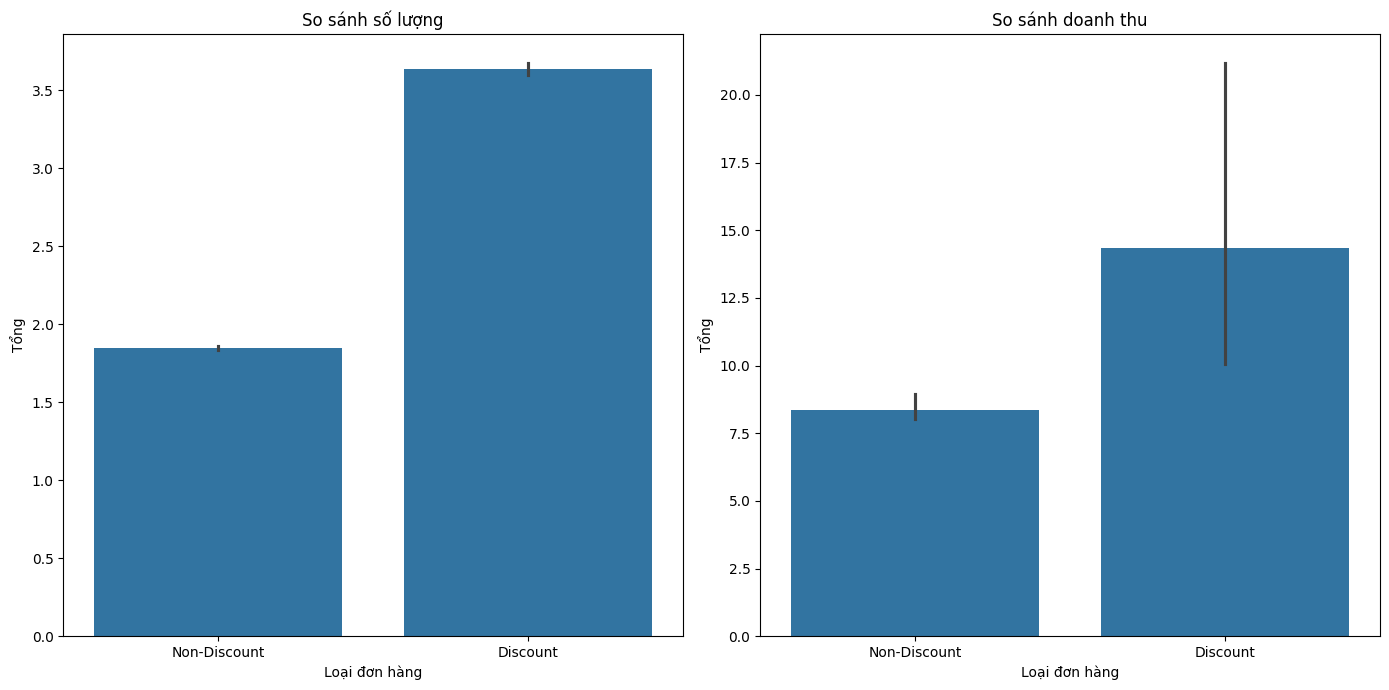

In [352]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.barplot(data=combined_df, x='order_type', y='Quantity')
plt.title('So sánh số lượng')
plt.xlabel('Loại đơn hàng')
plt.ylabel('Tổng')

# Vẽ biểu đồ so sánh doanh thu
plt.subplot(1, 2, 2)
sns.barplot(data=combined_df, x='order_type', y='SalesAmount')
plt.title('So sánh doanh thu')
plt.xlabel('Loại đơn hàng')
plt.ylabel('Tổng')

plt.tight_layout()
plt.show()

In [353]:
combined_df.groupby('order_type')['Quantity'].mean()

order_type
Discount       3.64
Non-Discount   1.85
Name: Quantity, dtype: float64

Nhận xét: Đơn hàng có giảm giá có số lượng trung bình món ăn và doanh thu cao hơn các đơn hàng không có giảm giá

##### 4.4.3 So sánh từng cửa hàng

###### 4.4.3.1 So sánh trung bình số lượng món và doanh thu của mỗi đơn hàng

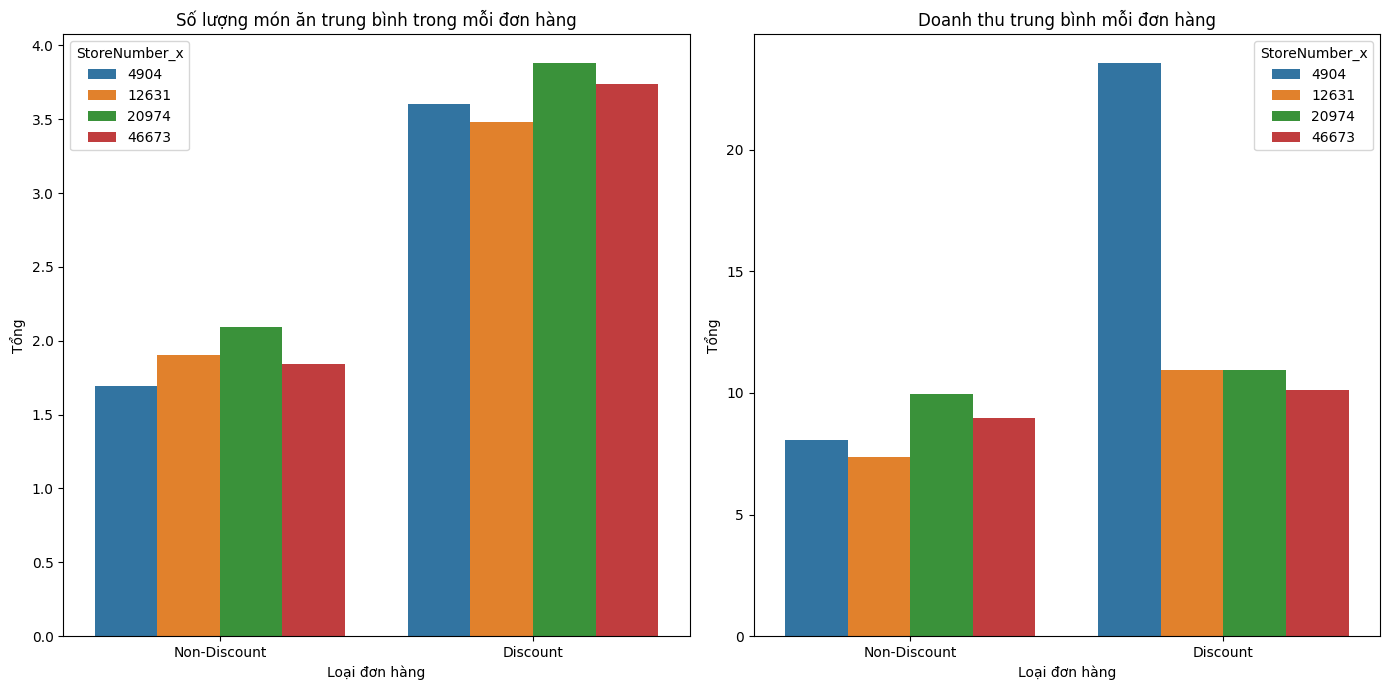

In [354]:
plt.figure(figsize=(14, 7))

# So sánh trung bình các chỉ số
plt.subplot(1, 2, 1)
sns.barplot(data=combined_df.groupby(['order_type', 'StoreNumber_x']).agg(Quantity=('Quantity', 'mean')).reset_index(),
            x='order_type',
            y='Quantity',
            hue='StoreNumber_x',
            order=['Non-Discount', 'Discount'],
            palette='tab10')
plt.title('Số lượng món ăn trung bình trong mỗi đơn hàng')
plt.xlabel('Loại đơn hàng')
plt.ylabel('Tổng')

plt.subplot(1, 2, 2)
sns.barplot(data=combined_df.groupby(['order_type', 'StoreNumber_x']).agg(SalesAmount=('SalesAmount', 'mean')).reset_index(),
            x='order_type',
            y='SalesAmount',
            hue='StoreNumber_x',
            order=['Non-Discount', 'Discount'],
            palette='tab10')
plt.title('Doanh thu trung bình mỗi đơn hàng')
plt.xlabel('Loại đơn hàng')
plt.ylabel('Tổng')

plt.tight_layout()
plt.show()

Nhận xét
- Chương trình giảm giá dường như có tác động tốt trong việc tăng số lượng món ăn ở của mỗi đơn hàng ở tất cả các cửa hàng, đặc biệt ở cửa hàng 4904.
- Chương trình giảm giá cũng giúp doanh thu mỗi đơn hàng tăng đặc biệt ở cửa hàng 4904

In [355]:
combined_df.pivot_table(
  index='order_type',
  columns='StoreNumber_x',
  values='Quantity',
  aggfunc='mean')

StoreNumber_x,4904,12631,20974,46673
order_type,,,,
Discount,3.60,3.48,3.88,3.74
Non-Discount,1.70,1.91,2.09,1.84


In [356]:
combined_df.pivot_table(
  index='order_type',
  columns='StoreNumber_x',
  values='SalesAmount',
  aggfunc='mean')

StoreNumber_x,4904,12631,20974,46673
order_type,,,,
Discount,23.55,10.92,10.96,10.11
Non-Discount,8.05,7.35,9.97,8.96


###### 4.4.3.2 So sánh tổng số lượng món, đơn hàng, và doanh thu

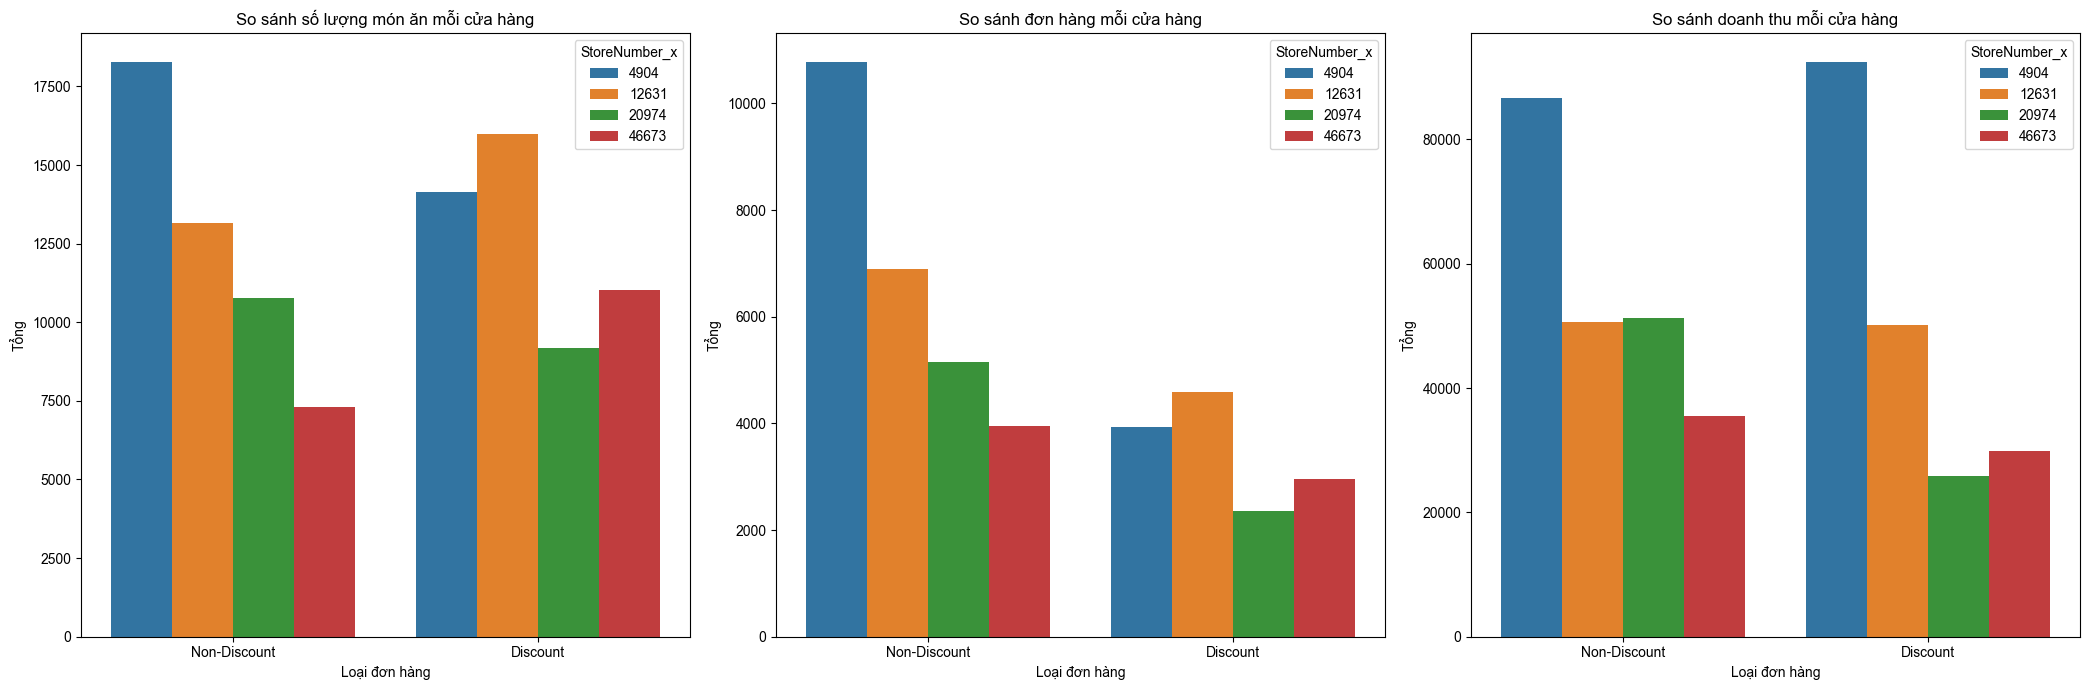

In [357]:
plt.figure(figsize=(21, 7))

# So sánh trung bình các chỉ số
plt.subplot(1, 3, 1)
sns.barplot(data=combined_df.groupby(['order_type', 'StoreNumber_x']).agg(Quantity=('Quantity', 'sum')).reset_index(),
            x='order_type',
            y='Quantity',
            hue='StoreNumber_x',
            order=['Non-Discount', 'Discount'],
            palette='tab10')
plt.title('So sánh số lượng món ăn mỗi cửa hàng')
plt.xlabel('Loại đơn hàng')
plt.ylabel('Tổng')

plt.subplot(1, 3, 2)
sns.barplot(data=combined_df.groupby(['order_type', 'StoreNumber_x']).agg(total_order=('MD5KEY_ORDERSALE', 'count')).reset_index(),
            x='order_type',
            y='total_order',
            hue='StoreNumber_x',
            order=['Non-Discount', 'Discount'],
            palette='tab10')
plt.title('So sánh đơn hàng mỗi cửa hàng')
plt.xlabel('Loại đơn hàng')
plt.ylabel('Tổng')

plt.subplot(1, 3, 3)
sns.barplot(data=combined_df.groupby(['order_type', 'StoreNumber_x']).agg(SalesAmount=('SalesAmount', 'sum')).reset_index(),
            x='order_type',
            y='SalesAmount',
            hue='StoreNumber_x',
            order=['Non-Discount', 'Discount'],
            palette='tab10')
sns.set_style("whitegrid")
plt.title('So sánh doanh thu mỗi cửa hàng')
plt.xlabel('Loại đơn hàng')
plt.ylabel('Tổng')

plt.tight_layout()
plt.show()

Nhận xét:

Số lượng món ăn
- Cửa hàng 4904 có tổng số lượng món ăn cao nhất trong các đơn hàng không giảm giá.
- Trong các đơn hàng giảm giá, cửa hàng 12631 có số lượng món ăn cao nhất, tiếp theo là cửa hàng 4904.

Số lượng đơn hàng
- Cửa hàng 4904 cũng dẫn đầu về số lượng đơn hàng không giảm giá.
- Cửa hàng 12631 có số lượng đơn hàng giảm giá cao nhất, tiếp theo là cửa hàng 4904

Doanh thu
- Cửa hàng 4904 có doanh thu cao nhất trong cả hai loại đơn hàng.
- Doanh thu từ các đơn hàng không giảm giá cao hơn so với doanh thu từ các đơn hàng giảm giá ở hầu hết các cửa hàng.

In [358]:
# Check dữ liệu trước và sau merge
print(df_menuitem['SalesAmount'].sum())
print(combined_df['SalesAmount'].sum())

422607.57
422607.57


In [359]:
print('Doanh thu đơn hàng không giảm giá:', combined_df[combined_df['order_type'] == 'Non-Discount']['SalesAmount'].sum())
print('Doanh thu đơn hàng có giảmm giá:', combined_df[combined_df['order_type'] == 'Discount']['SalesAmount'].sum())
print('Kiểm tra tổng:', combined_df[combined_df['order_type'] == 'Non-Discount']['SalesAmount'].sum() + combined_df[combined_df['order_type'] == 'Discount']['SalesAmount'].sum())

Doanh thu đơn hàng không giảm giá: 224220.66999999998
Doanh thu đơn hàng có giảmm giá: 198386.90000000002
Kiểm tra tổng: 422607.57
